<a href="https://colab.research.google.com/github/valleyofdawn/FastTag/blob/main/FastTag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single cell annotation pipline

## Prep

### Install missing libraries

In [3]:
!pip install google-cloud-storage scanpy anndata mygene harmonypy igraph leidenalg scikit-misc --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.9 MB/s eta 0:00:00


### load libraries

In [131]:
from anndata import AnnData # for rading 10x format
from google.cloud import storage
from google.colab import auth, drive
from pathlib import Path # needed for multiple file input
from scipy import sparse as sp
from scipy.io import mmread
from scipy.sparse import csr_matrix # for rading 10x format
from scipy.stats import zscore, pearsonr, ttest_ind, ttest_rel # for leave-one-out marker pruning
from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler, minmax_scale
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from typing import Literal, Sequence, Tuple, Optional

import anndata as ad # needed throughout
import gc, glob, gzip, h5py, harmonypy as hm, igraph as ig, io, matplotlib.pyplot as plt
import mygene as mg, numpy as np, openai, os, pandas as pd, re, requests, scanpy as sc, scipy.sparse as sp, seaborn as sns
import tarfile, textwrap, time, yaml


### Set variables

In [5]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
set4 =  ['darkgreen', 'cornflowerblue', 'darkred', 'plum', 'orange',
    'magenta', 'lightgreen', 'tan', 'slateblue', 'gray', 'turquoise',
    'coral', 'lightgray', 'green', 'pink', 'gold', 'peru',
    'red', 'olive', 'lime', 'teal', 'skyblue', 'violet',
    'crimson', 'beige', 'lightgrey',  'thistle','darkorange',
    'lightgreen', 'blue', 'wheat','orchid']

plt.rcParams['figure.figsize'] = (6, 6)
os.environ['LOKY_MAX_CPU_COUNT'] = '12'
pd.set_option('display.float_format', '{:.2e}'.format)

### Connect

In [6]:
from google.colab import userdata
userdata.get('openai_client')
# os.chdir('/content/')
# print('Current working directory:', os.getcwd())
auth.authenticate_user()
client = storage.Client(project='Scanpy for Biolojic')
bucket = client.bucket('single_cell_h5ad_datasets')

### Function definitions

#### Make Pseudobulk

In [96]:
def generate_pseudobulk_matrix(
    adata, groupby_cols: list = ['patient', 'timepoint']
):
    obs = adata.obs[groupby_cols].copy()

    # Combine grouping columns into a single label
    group_labels = obs.astype(str).agg('_'.join, axis=1)
    unique_labels = group_labels.unique()

    # Access expression matrix
    X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    df = pd.DataFrame(X, index=group_labels, columns=adata.var_names)

    # Compute mean expression per group
    pseudobulk = df.groupby(level=0).mean()

    # Recover metadata from group_labels
    metadata = pd.DataFrame(
        [label.split('_') for label in pseudobulk.index],
        columns=groupby_cols,
        index=pseudobulk.index
    )

    # Return metadata + expression matrix
    return pd.concat([metadata, pseudobulk], axis=1)


#### Pseudobulk T-test

In [97]:
def ttest_pseudobulk(
    pb_df,
    gene: str,
    condition_col: str = "treatment",
    subject_col: str = "patient", # Modified: Default remains 'patient'
    paired: bool = True, # Modified: Default remains True
    alternative: str = "both",  # 'both', 'pos', 'neg'
):
    """
    Perform a t-test on pseudobulk data for a given gene.

    Parameters
    ----------
    pb_df : pd.DataFrame
        Pseudobulk matrix with subjects, conditions, and gene expression.
    gene : str
        Gene name (must be a column in pb_df).
    condition_col : str
        Column name indicating treatment condition.
    subject_col : str or None
        Column name identifying subjects (for pairing). If None, performs unpaired test.
    paired : bool
        Whether to use a paired t-test. Ignored if subject_col is None.
    alternative : str
        'both' = two-sided, 'pos' = greater (treated > control), 'neg' = less.

    Returns
    -------
    t_stat : float
    p_value : float
    summary : str
        Text summary of test result.
    """
    df = pb_df[[col for col in [subject_col, condition_col, gene] if col is not None]].dropna() # Modified: Select columns only if they are not None
    conditions = df[condition_col].unique()

    if len(conditions) != 2:
        raise ValueError("T-test requires exactly two conditions.")

    cond1, cond2 = sorted(conditions)  # ensure consistent order

    # Modified: Check if subject_col is None or paired is False
    if subject_col is None or not paired:
        print("Performing unpaired t-test.")
        x1 = df[df[condition_col] == cond1][gene].values
        x2 = df[df[condition_col] == cond2][gene].values
        t_stat, p_val = ttest_ind(x2, x1, equal_var=False) # Use independent t-test
        paired = False # Ensure summary is correct
    else: # Original paired test logic
        print("Performing paired t-test.")
        if subject_col not in df.columns: # Added check
             raise ValueError(f"Subject column '{subject_col}' not found in DataFrame for paired test.")
        df_pivot = df.pivot(index=subject_col, columns=condition_col, values=gene).dropna()
        x1 = df_pivot[cond1].values
        x2 = df_pivot[cond2].values
        t_stat, p_val = ttest_rel(x2, x1)

    # Adjust for one-sided alternatives
    if alternative == "both":
        pass  # already correct
    elif alternative == "pos":  # treated > control
        if t_stat > 0:
            p_val /= 2
        else:
            p_val = 1 - (1 - p_val / 2)
    elif alternative == "neg":  # treated < control
        if t_stat < 0:
            p_val /= 2
        else:
            p_val = 1 - (1 - p_val / 2)
    else:
        raise ValueError("alternative must be one of: 'both', 'pos', 'neg'")

    summary = f"T-test ({'paired' if paired else 'unpaired'}, {alternative}): {cond2} vs {cond1} — t = {t_stat:.3f}, p = {p_val:.3e}"
    return t_stat, p_val, summary

#### T-test

In [98]:
def paired_ttest(pb_df, cond1='untreated', cond2='treated',
                               expr_threshold=0.1, fold_change_threshold=1.5,
                               group_col='treatment_group', subject_col='patient'):
    """
    Perform a fast, batched paired one-sided t-test on pseudobulk expression data.
    Filters genes expressed in at least `expr_threshold` fraction of subjects in cond2
    and with fold change ≥ `fold_change_threshold`.
    """
    from scipy.stats import ttest_rel
    import pandas as pd

    # Pivot to subject × (condition, gene) matrix
    wide_df = pb_df.pivot(index=subject_col, columns=group_col)

    # Get all genes (exclude multi-index level 0 which is 'expr')
    all_genes = wide_df.columns.levels[1]

    results = []

    for gene in all_genes:
        try:
            x1 = wide_df[cond1][gene]
            x2 = wide_df[cond2][gene]
        except KeyError:
            continue  # Skip genes missing in either group

        # Drop subjects with missing data in either condition
        valid_mask = x1.notna() & x2.notna()
        x1 = x1[valid_mask]
        x2 = x2[valid_mask]

        if len(x1) < 3:
            continue

        # Expression threshold: at least X% of subjects in cond2 express the gene
        expr_pct = (x2 > 0).sum() / len(x2)
        if expr_pct < expr_threshold:
            continue

        # Fold change
        fc = (x2.mean() + 1e-6) / (x1.mean() + 1e-6)
        if fc < fold_change_threshold:
            continue

        # Paired one-sided t-test (cond2 > cond1)
        stat, pval = ttest_rel(x2, x1, alternative='greater')

        results.append({
            'gene': gene,
            'fold_change': fc,
            'expr_pct_treated': expr_pct,
            'pval': pval,
            'n_pairs': len(x1)

        })

    return pd.DataFrame(results).sort_values('pval')


#### Fetch

In [99]:
def fetch(filenames: list):
  """Downloads a list of files from the specified GCS bucket.

  Args:
    filenames: A list of strings, where each string is a filename in the GCS
      bucket.
  """
  if isinstance(filenames, str):
    filenames = [filenames]
  for filename in filenames:
    # Extract only the base filename
    base_filename = os.path.basename(filename)
    blob = bucket.blob(filename)
    # Download to /content/ with just the base filename
    blob.download_to_filename(f'/content/{base_filename}')

#### Cell time course

In [100]:
def plot_timecourse(
    adata,
    features,
    time_key='week',         # Must be numeric (e.g. 0, 1, 2, ...)
    patient_key='patient_id',
    split_by=None,
    color_by=None,
    sem=True,
    relative=False,
    figsize=(10, 6),
    ylim=(None, None),
    ymin_zero=True
):
    fig, ax = plt.subplots(figsize=figsize)

    for feature in features:
        # Extract expression
        if feature in adata.obs.columns:
            vals = adata.obs[feature]
        elif adata.raw is not None and feature in adata.raw.var_names:
            arr = (
                adata.raw[:, feature].X.toarray().ravel()
                if sp.issparse(adata.raw.X)
                else adata.raw[:, feature].X.ravel()
            )
            vals = pd.Series(arr, index=adata.obs_names, name=feature)
        else:
            raise KeyError(f"Feature '{feature}' not found in obs or raw.")

        # Build base dataframe
        df = pd.DataFrame({
            time_key: pd.to_numeric(adata.obs[time_key], errors='coerce'),
            patient_key: adata.obs[patient_key].astype(str),
            feature: vals.values
        }).dropna(subset=[time_key])
        if split_by:
            df[split_by] = adata.obs[split_by].astype(str)
        if color_by:
            df[color_by] = adata.obs[color_by].astype(str)

        group_cols = [time_key, split_by] if split_by else [time_key]

        # Step 1: Aggregate per patient
        patient_means = (
            df.groupby([time_key, patient_key] + ([split_by] if split_by else []), observed=True)[feature]
              .mean()
              .reset_index()
        )

        # Step 2: Compute stats across patients
        stats = (
            patient_means
            .groupby(group_cols, observed=True)[feature]
            .agg(mean='mean', std='std', count='count')
            .reset_index()
        )
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])
        if split_by:
            stats[split_by] = stats[split_by].astype(str)

        # Optional: Add color_by (e.g. genotype)
        if color_by:
            color_lookup = (
                df.groupby(group_cols, observed=True)[color_by]
                  .agg(lambda x: x.mode().iloc[0])
                  .reset_index()
            )
            stats = stats.merge(color_lookup, on=group_cols, how='left')
            categories = sorted(df[color_by].unique())
            palette = sns.color_palette("Set2", len(categories))
            color_dict = dict(zip(categories, palette))

        # Relative expression (% of baseline)
        if relative:
            if split_by:
                stats['mean'] = stats.groupby(split_by)['mean'].transform(
                    lambda x: (x / x.iloc[0]) * 100 if x.iloc[0] > 0 else 0
                )
                stats['sem'] = stats.groupby(split_by)['sem'].transform(
                    lambda x: (x / x.iloc[0]) * 100 if x.iloc[0] > 0 else 0
                )
            else:
                base = stats['mean'].iloc[0]
                stats['mean'] = (stats['mean'] / base) * 100 if base > 0 else 0
                stats['sem'] = (stats['sem'] / base) * 100 if base > 0 else 0
            y_label = 'Relative mean expression (%)'
        else:
            y_label = "Mean ± SEM" if sem else "Mean"

        # Plotting
        if split_by:
            for _, subdf in stats.groupby(split_by, observed=True):
                subdf = subdf.sort_values(by=time_key)
                label = subdf[split_by].iloc[0]
                color_val = subdf[color_by].iloc[0] if color_by else None
                color = color_dict[color_val] if color_by else None

                ax.errorbar(
                    subdf[time_key],
                    subdf['mean'],
                    yerr=subdf['sem'] if sem else None,
                    marker='o',
                    linestyle='-',
                    label=label,
                    linewidth=1,
                    color=color
                )
        else:
            stats = stats.sort_values(by=time_key)
            label = feature
            color_val = stats[color_by].iloc[0] if color_by else None
            color = color_dict[color_val] if color_by else None

            ax.errorbar(
                stats[time_key],
                stats['mean'],
                yerr=stats['sem'] if sem else None,
                marker='o',
                linestyle='-',
                label=label,
                linewidth=1,
                color=color
            )

    # Legend
    legend_title = split_by.capitalize() if split_by else "Feature"
    ax.legend(title=legend_title, loc="upper left", bbox_to_anchor=(1.02, 1))

    # Labels and styling
    ax.set_xlabel(time_key)
    ax.set_ylabel(y_label)
    title = f"Time course of {features[0]}" if len(features) == 1 else "Time course of features"
    ax.set_title(title)

    # Y-axis control
    if ymin_zero:
        ax.set_ylim(bottom=0, top=ylim[1])
    else:
        ax.set_ylim(ylim)

    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


#### Find Markers

In [101]:
def markers(cell_type, sign='pos', markers_yaml="markers.yaml", ontology_yaml="ontology.yaml", adata=None):
    if sign not in {'pos', 'neg'}:
        raise ValueError("sign must be 'pos' or 'neg'")

    # Re-load and normalize markers from YAML files
    _, normalized_markers = init_ontology(ontology_yaml, markers_yaml, root="root")

    if cell_type not in normalized_markers:
        print(f"⚠️ Cell type '{cell_type}' not found in marker definitions. Skipping.")
        return []

    markers_raw = normalized_markers[cell_type][sign]

    if adata is not None:
        var_names = adata.raw.var_names if getattr(adata, 'raw', None) is not None else adata.var_names
        present = [g for g in markers_raw if g in var_names]
        missing = [g for g in markers_raw if g not in var_names]
        for g in missing:
            print(f"⚠️ Marker '{g}' not found in data. Skipping.")
        return present

    return markers_raw


#### Analyze cell type distribution

In [102]:
def analyze_cell_type_distribution(
    adata,
    groupby='timepoint',
    control_group='Control',
    key_added='FastTag',
    sample='patient',
    paired=False
):

    df = adata.obs[[key_added, sample, groupby]].copy()

    # Sanity check: control group exists
    group_vals = df[groupby].unique()
    if control_group not in group_vals:
        raise ValueError(f"control_group '{control_group}' not found in '{groupby}' values: {group_vals}")

    # Count and percent cell types per sample
    counts = df.groupby([sample, groupby, key_added], observed=True).size().unstack(fill_value=0)
    pct = counts.div(counts.sum(axis=1), axis=0) * 100
    pct = pct.sort_index(level=[groupby, sample])

    # Reorder cell types
    cell_types = list(pct.columns)
    if 'Treg' in cell_types:
        cell_types.remove('Treg')
        cell_types = ['Treg'] + cell_types

        # Plot stacked barplot with grouped samples and spacing
    fig, ax = plt.subplots(figsize=(40, 10))
    colors = plt.cm.tab20.colors

    # Extract group/sample info
    index_df = pct.index.to_frame(index=False)
    groups = index_df[groupby].unique()
    spacer = 1  # gap between groups

    bar_positions = []
    xtick_positions = []
    xtick_labels = []
    plot_data = []

    pos = 0
    for grp in groups:
        sub = pct.loc[pct.index.get_level_values(groupby) == grp]
        n = len(sub)
        bar_positions.extend(range(pos, pos + n))
        xtick_positions.append(pos + n / 2 - 0.5)
        xtick_labels.append(grp)
        plot_data.append(sub)
        # spacer row (NaNs → zeros later)
        plot_data.append(pd.DataFrame(np.nan, index=range(spacer), columns=sub.columns))
        pos += n + spacer

    stacked_df = pd.concat(plot_data, ignore_index=True).fillna(0)

    bottom = np.zeros(len(stacked_df))
    for i, ct in enumerate(cell_types):
        ax.bar(range(len(stacked_df)), stacked_df[ct].values, bottom=bottom,
               label=ct, color=colors[i % len(colors)])
        bottom += stacked_df[ct].values

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, fontsize=16)
    ax.set_ylabel('Percentage of Cells (%)')
    ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()



#### Cell count table

In [103]:
def cell_count_table(
    adata,
    row='FastTag',
    column=None,
    show_sample_counts=False,
    sample_col='donor_id',
    fill_value='0',
    display_full=False,
):
    # Grouping variables
    group_keys = [row] if column is None else [row, column]

    # Count cells
    cell_counts = (
        adata.obs
        .groupby(group_keys, observed=True)
        .size()
        .reset_index(name='cell_count')
    )

    if show_sample_counts:
        sample_counts = (
            adata.obs
            .groupby(group_keys, observed=True)[sample_col]
            .nunique()
            .reset_index(name='sample_count')
        )
        merged = pd.merge(cell_counts, sample_counts, on=group_keys)
        merged['info'] = (
            merged['cell_count'].astype(str) +
            ' (' + merged['sample_count'].astype(str) + ')'
        )
        value_col = 'info'
    else:
        merged = cell_counts
        merged['info'] = merged['cell_count'].astype(str)
        value_col = 'info'

    if column is None:
        table = merged.set_index(row)[value_col]
    else:
        table = merged.pivot_table(
            index=row,
            columns=column,
            values=value_col,
            fill_value=fill_value,
            aggfunc='first',
            observed=True
        )

    if display_full:
        pd.set_option('display.max_rows', None)
        display(table)
    else:
        print(table)
        print(f"Total cell count: {cell_counts['cell_count'].sum()}")

#### Volcano auc

In [104]:
def volcano_auc_split(
    df: pd.DataFrame,
    fold_change_col: str = 'log2fc',
    pval_col: str = 'pval',
) -> tuple[float, float]:
    """
    Compute separate AUCs for upregulated and downregulated genes from a volcano plot.

    Returns:
    --------
    auc_up : float
        AUC over genes with log2FC > 0
    auc_down : float
        AUC over genes with log2FC < 0
    """
    sub = df[[fold_change_col, pval_col]].dropna().copy()
    sub = sub[sub[pval_col] > 0]
    sub['neglog10p'] = -np.log10(sub[pval_col])

    # Sort and split
    sub = sub.sort_values(fold_change_col)
    up = sub[sub[fold_change_col] > 0]
    down = sub[sub[fold_change_col] < 0]

    auc_up = np.trapezoid(up['neglog10p'], up[fold_change_col]) if not up.empty else 0.0
    auc_down = np.trapezoid(down['neglog10p'], down[fold_change_col]) if not down.empty else 0.0

    return auc_up, auc_down


#### Save cell dictionary

In [105]:
def save_dict(adata_dict, output_path, compression='gzip', compression_opts=1):
    adata_list = []

    for category, adata in adata_dict.items():
        # Ensure in-memory AnnData (avoid .backed mode)
        if getattr(adata, 'isbacked', False):
            adata = adata.to_memory()

        adata = adata.copy()
        adata.obs['cell_category'] = category
        adata_list.append(adata)

    # Concatenate all objects
    merged = ad.concat(
        adata_list,
        axis=0,
        join='outer',
        label=None,
        fill_value=0
    )

    # Save with compression (if HDF5 format)
    merged.write(output_path, compression=compression, compression_opts=compression_opts)

    return merged


#### Downsample

In [106]:
def downsample (adata, groupby, n_cells):
    sampled_indices = (
        adata.obs
        .groupby(groupby, group_keys=False)
        .apply(lambda x: x.sample(min(n_cells, len(x)), random_state=0))
        .index
    )
    return adata[sampled_indices].copy()

#### Subset data

In [107]:
def subset(adata, column: str, value) -> 'AnnData':
    if adata.raw is None:
        raise ValueError('AnnData.raw is not set. Cannot subset raw data.')

    if column not in adata.obs.columns:
        raise KeyError(f"Column '{column}' not found in adata.obs.")

    mask = adata.obs[column] == value
    if mask.sum() == 0:
        raise ValueError(f"No cells found where adata.obs['{column}'] == {value!r}")

    adata_sub = adata[mask].copy()
    adata_sub.raw = adata.raw.to_adata()[mask].copy()
    return adata_sub


#### Purge rare cells

In [108]:
def purge(adata, column, min_count=10):
    if column not in adata.obs:
        raise ValueError(f"Column '{column}' not found in adata.obs.")

    # Count instances per category
    counts = adata.obs[column].value_counts()

    # Determine valid (frequent enough) categories
    valid_categories = counts[counts >= min_count].index

    # Create boolean mask for cells to keep
    keep_mask = adata.obs[column].isin(valid_categories)

    # Apply mask to keep only relevant cells
    adata._inplace_subset_obs(keep_mask)

    # Clean up unused categories if applicable
    if pd.api.types.is_categorical_dtype(adata.obs[column]):
        adata.obs[column] = adata.obs[column].cat.remove_unused_categories()


#### Convert to HGNC

In [109]:
def convert(adata):
    """
    Convert var_names (and raw.var_names) from Ensembl IDs or aliases to official gene symbols.
    Stores original names in adata.var['original_gene'] and, if raw exists, in adata.raw.var['original_gene'].
    """
    mg_client = mg.MyGeneInfo()

    # Guess ID type on a small sample
    sample = adata.var_names[:20]
    if any(re.match(r'ENSG\d{9}', g) for g in sample):
        print('🔄 Looks like Ensembl IDs — converting to gene symbols.')
        query_args = dict(scopes='ensembl.gene', fields='symbol', species='human')
    else:
        print('🔄 Looks like gene symbols — converting aliases to official symbols.')
        query_args = dict(scopes='symbol,alias', fields='symbol', species='human')

    # Query MyGeneInfo
    results = mg_client.querymany(adata.var_names.tolist(), **query_args)
    mapping = {entry['query']: entry.get('symbol', entry['query']) for entry in results}

    # Backup original var_names in var
    adata.var['original_gene'] = adata.var_names.copy()

    # Map var_names
    new_names = adata.var_names.map(lambda g: mapping.get(g, g))
    adata.var_names = new_names
    adata.var_names_make_unique()

    # Also update raw.var_names if raw exists
    if adata.raw is not None:
        # Backup raw original names
        adata.raw.var['original_gene'] = adata.raw.var_names.copy()
        # Apply new names to raw.var
        adata.raw.var.index = adata.var_names.copy()

    num_changed = (adata.var['original_gene'] != adata.var_names).sum()
    print(f"✅ Conversion complete. {num_changed} gene names were changed.")
    return adata


#### Split dataset

In [110]:

def split(adata, category, min_cells=20, skip_unknown=True):
    labels = adata.obs[category].unique()
    subsets = {}

    for label in labels:
        if skip_unknown and label == 'Unknown':
            continue

        ad_subset = adata[adata.obs[category] == label].copy()
        if ad_subset.n_obs >= min_cells:
            subsets[label] = ad_subset

    return subsets

#### Enrich

In [111]:
def enrich_all(genes, description='Example gene list'):
    library_list = [
        'Azimuth_2023',
        'CellMarker_2024',
        'HuBMAP_ASCTplusB_augmented_2022',
        'PanglaoDB_Augmented_2021',
        'Tabula_Sapiens'
    ]
    # library_list = [
    #     'Reactome_Pathways_2024',
    #     'WikiPathways_2024_Human',
    #     'BioPlanet_2019',
    #     'KEGG_2021_Human',
    #     'Elsevier_Pathway_Collection'
    # ]

    combined_results = []

    for library_name in library_list:
        time.sleep(1)  # Avoid rate limiting
        payload = {'list': '\n'.join(genes), 'description': description}
        response = requests.post('https://maayanlab.cloud/Enrichr/addList', files=payload)

        if response.status_code != 200:
            raise Exception('Error analyzing gene list:', response.text)

        user_list_id = response.json().get('userListId')
        results_url = f'https://maayanlab.cloud/Enrichr/enrich?userListId={user_list_id}&backgroundType={library_name}'
        enrichment_response = requests.get(results_url)

        if enrichment_response.status_code != 200:
            raise Exception('Error fetching enrichment results:', enrichment_response.text)

        enrichment_data = enrichment_response.json().get(library_name, [])
        if not enrichment_data:
            continue

        # Convert to dataframe
        results_df = pd.DataFrame([
            {
                'Library': library_name,
                'Term': row[1],
                'PValue': float(row[2]),
                'AdjustedPValue': float(row[6]),
                'OverlappingGenes': ', '.join(row[5])
            }
            for row in enrichment_data
        ])

        combined_results.append(results_df)

    if not combined_results:
        return pd.DataFrame()

    combined_df = pd.concat(combined_results, ignore_index=True)

    # Filter results
    combined_df = combined_df[combined_df['AdjustedPValue'] < 0.01]
    combined_df = combined_df[combined_df['OverlappingGenes'].str.split(', ').map(len) > 3]

    return combined_df

#### ChatGPT

In [112]:
def ChatGPT(gene_set, cell_category, tissue, model='gpt-4o'):
    # Construct the prompt
    prompt = f'''
You are a biomedical expert. Based on your knowledge of gene expression and cellular specialization,
assess which {cell_category} in the {tissue} are most likely to differentially express the following gene set:

{', '.join(gene_set)}

Consider the gene set as a whole. Do not assess each gene individually.

List only the relevant cell types, each with a summary likelihood:
'very likely', 'possibly', or 'unlikely'.

Present your answer in this format:

- Cell_Type_A: very likely
- Cell_Type_B: possibly
'''

    # Query ChatGPT
    response = openai_client.chat.completions.create(
        model=model,
        messages=[{'role': 'user', 'content': prompt}],
        temperature=0.3
    )

    # Extract and parse text response
    text = response.choices[0].message.content
    lines = text.splitlines()

    # Filter and parse into tuples
    parsed = []
    for line in lines:
        if ':' in line:
            cell_type, likelihood = line.split(':', 1)
            parsed.append((cell_type.strip(' -*•'), likelihood.strip().lower()))

    # Sort by likelihood level
    likelihood_order = {'very likely': 0, 'possibly': 1, 'unlikely': 2}
    parsed_sorted = sorted(parsed, key=lambda x: likelihood_order.get(x[1], 3))

    # Convert to DataFrame
    df = pd.DataFrame(parsed_sorted, columns=['Cell Type', 'Likelihood'])
    return df

#### DGE computation

In [113]:
def DGE(
    adata,
    target_group,
    reference_group,
    groupby,
    min_pct=None,
    min_log2fc=None,
    min_delta_pct=None,
    direction='pos',  # 'pos', 'neg', or 'both'
    n_genes=200,
    n_sample=None,
    return_df=False,
):
    """
    Differential Gene Expression for log-transformed data with optional Δpct and fold-change filters.
    Performs Welch's t-test and FDR correction. Assumes adata.raw is log-normalized data.
    """

    if direction not in ('pos', 'neg', 'both'):
        raise ValueError("direction must be one of 'pos', 'neg', or 'both'")
    if adata.raw is None:
        raise ValueError("`adata.raw` must be set before running DGE().")
    if isinstance(target_group, str):
        target_group = [target_group]

    labels = adata.obs[groupby].values
    tmask = np.isin(labels, target_group)
    rmask = ~tmask if reference_group == 'rest' else (labels == reference_group)

    def subsample(mask):
        idx = np.where(mask)[0]
        if n_sample is not None and len(idx) > n_sample:
            return np.random.choice(idx, size=n_sample, replace=False)
        return idx

    t_idx = subsample(tmask)
    r_idx = subsample(rmask)
    X = adata.raw.X
    var_names = adata.raw.var_names
    X_t = X[t_idx]
    X_r = X[r_idx]
    nt, nr = len(t_idx), len(r_idx)

    # Means and % expressing
    if sp.issparse(X):
        mean_t = X_t.mean(axis=0).A1
        mean_r = X_r.mean(axis=0).A1
        pct_t = X_t.getnnz(axis=0) / nt
        pct_r = X_r.getnnz(axis=0) / nr
        X_t_dense = X_t.toarray()
        X_r_dense = X_r.toarray()
    else:
        mean_t = X_t.mean(axis=0)
        mean_r = X_r.mean(axis=0)
        pct_t = (X_t > 0).mean(axis=0)
        pct_r = (X_r > 0).mean(axis=0)
        X_t_dense = X_t
        X_r_dense = X_r

    log2fc = mean_t - mean_r
    delta_pct = pct_t - pct_r

    # Filter before statistical test
    if direction == 'both':
        fc_mask = np.abs(log2fc) >= (min_log2fc or 0)
        dp_mask = np.abs(delta_pct) >= (min_delta_pct or 0)
    elif direction == 'pos':
        fc_mask = log2fc >= (min_log2fc or 0)
        dp_mask = delta_pct >= (min_delta_pct or 0)
    else:  # 'neg'
        fc_mask = log2fc <= -(min_log2fc or 0)
        dp_mask = delta_pct <= -(min_delta_pct or 0)

    pct_mask = pct_t >= (min_pct or 0)
    keep_mask = np.logical_and.reduce([pct_mask, fc_mask, dp_mask])
    kept = np.where(keep_mask)[0]

    if kept.size == 0:
        print("⚠️ No genes passed the filtering criteria.")
        return pd.DataFrame(columns=[
            'gene', 'mean_target', 'mean_ref',
            'pct_target', 'pct_ref', 'delta_pct',
            'log2fc', 'pval', 'pval_adj'
        ]) if return_df else []

    # Run t-tests only on filtered genes
    X_t_dense = X_t_dense[:, kept]
    X_r_dense = X_r_dense[:, kept]
    _, pvals = ttest_ind(X_t_dense, X_r_dense, axis=0, equal_var=False)
    pvals = np.asarray(pvals)

    # Adjust p-values
    adj_pvals = np.full_like(pvals, np.nan, dtype=np.float64)
    valid = ~np.isnan(pvals)
    if valid.sum() > 0:
        adj_pvals[valid] = multipletests(pvals[valid], method='fdr_bh')[1]
    else:
        print("⚠️ All p-values are NaN — no FDR correction performed.")

    # Assemble results
    df = pd.DataFrame({
        'gene': var_names[kept],
        'mean_target': mean_t[kept],
        'mean_ref': mean_r[kept],
        'pct_target': pct_t[kept],
        'pct_ref': pct_r[kept],
        'delta_pct': delta_pct[kept],
        'log2fc': log2fc[kept],
        'pval': pvals,
        'pval_adj': adj_pvals,
    })

    # Sort genes
    if direction == 'both':
        df = df.sort_values('pval')
    elif direction == 'neg':
        df = df.sort_values(['log2fc', 'pval'], ascending=[True, True])
    else:
        df = df.sort_values(['log2fc', 'pval'], ascending=[False, True])

    return df if return_df else df['gene'].head(n_genes).tolist()


#### get subscores

In [114]:
def subscores(root_cell, adata,
              markers_yaml='markers.yaml',
              ontology_yaml='ontology.yaml'):
    # init_ontology returns (G, markers)
    G, _ = init_ontology(ontology_yaml, markers_yaml, root_cell)

    # find the actual vertex for root_cell
    root_v = G.vs.find(name=root_cell)

    # now get all descendants (including the root itself)
    desc_idxs = G.subcomponent(root_v.index, mode='OUT')
    nodes = [G.vs[i]['name'] for i in desc_idxs]

    existing, missing = [], []
    for n in nodes:
        col = f"{n}_score"
        (existing if col in adata.obs else missing).append(col)

    if missing:
        print(f"⚠️ Missing score columns: {missing}")
    return existing


#### Remove non-coding genes

In [115]:
def coding_genes(adata, gene_id_type=None, chunk_size=1000):
    """
    Filter an AnnData object to retain only protein-coding genes.

    Parameters
    ----------
    adata : AnnData
        Input object.
    gene_id_type : str or None
        'symbol' (e.g. 'CD3D') or 'ensembl.gene' (e.g. 'ENSG00000167286').
        If None, it is guessed based on var_names.
    chunk_size : int
        Number of genes per MyGeneInfo query batch (max 1000).

    Returns
    -------
    AnnData with only protein-coding genes in .X (and .raw, if present).
    """
    import pandas as pd
    import numpy as np

    # --- Guess gene ID type if not provided ---
    if gene_id_type is None:
        ens_like = sum(g.startswith("ENS") for g in adata.var_names)
        gene_id_type = "ensembl.gene" if ens_like / len(adata.var_names) > 0.5 else "symbol"
    print(f"🔍 Querying MyGeneInfo with scope: '{gene_id_type}'")

    gene_list = adata.var_names.tolist()
    mg_client = mg.MyGeneInfo()

    # --- Query in chunks ---
    out = []
    for i in range(0, len(gene_list), chunk_size):
        chunk = gene_list[i:i + chunk_size]
        try:
            res = mg_client.querymany(
                chunk,
                scopes=gene_id_type,
                fields='type_of_gene',
                species='human',
                as_dataframe=True,
                df_index=True
            )
            out.append(res)
        except Exception as e:
            print(f"⚠️  Query failed on chunk {i}: {e}")

    df = pd.concat(out)

    # --- Keep clean hits only ---
    df = df[~df['notfound'].fillna(False)]
    if 'type_of_gene' not in df.columns:
        raise ValueError("❌ MyGeneInfo returned no 'type_of_gene' annotations.")

    # --- Map gene ID to biotype ---
    biotype_map = df['type_of_gene'].to_dict()
    adata_filtered = adata.copy()
    adata_filtered.var['gene_biotype'] = adata_filtered.var_names.map(biotype_map)

    coding_mask = adata_filtered.var['gene_biotype'] == 'protein-coding'
    adata_filtered = adata_filtered[:, coding_mask].copy()

    # --- Filter .raw if present ---
    if adata.raw is not None and isinstance(adata.raw, ad.AnnData):
        adata_filtered.raw = adata.raw[:, coding_mask].copy()

    print(f"✅ Filtered from {adata.n_vars} to {adata_filtered.n_vars} protein-coding genes.")
    return adata_filtered


#### QC computation

In [116]:
def compute_qc (adata):
    if adata.raw is None:
        raise ValueError('adata.raw is not set.')

    X = adata.raw.X
    gene_names = adata.raw.var_names

    # Define gene masks
    mt_mask = gene_names.str.startswith('MT-')
    ribo_mask = gene_names.str.startswith(('RPS', 'RPL'))
    hsp_mask = gene_names.str.startswith(('HSP', 'DNAJ'))

    # Convert sparse to dense row sums if needed
    row_sum = X.sum(axis=1).A1 if sp.issparse(X) else X.sum(axis=1)
    gene_count = (X > 0).sum(axis=1).A1 if sp.issparse(X) else (X > 0).sum(axis=1)

    mt_sum = X[:, mt_mask].sum(axis=1).A1 if sp.issparse(X) else X[:, mt_mask].sum(axis=1)
    ribo_sum = X[:, ribo_mask].sum(axis=1).A1 if sp.issparse(X) else X[:, ribo_mask].sum(axis=1)
    hsp_sum = X[:, hsp_mask].sum(axis=1).A1 if sp.issparse(X) else X[:, hsp_mask].sum(axis=1)

    # Assign to .obs
    adata.obs['total_counts'] = row_sum
    adata.obs['n_genes_by_counts'] = gene_count
    adata.obs['pct_counts_mt'] = (mt_sum / row_sum) * 100
    adata.obs['pct_counts_ribo'] = (ribo_sum / row_sum) * 100
    adata.obs['pct_counts_hsp'] = (hsp_sum / row_sum) * 100

    return adata


#### restore from raw

In [117]:
def restore_from_raw(adata):
  # Step 1: Rebuild AnnData with full expression from .raw
  adata_full = ad.AnnData(
      X = adata.raw.X,
      obs = adata.obs.copy(),
      var = adata.raw.var.copy()
  )
  adata_full.var_names = adata.raw.var_names

  # Step 2: Add embeddings and annotations
  adata_full.obsm.update(adata.obsm)
  adata_full.obsp.update(adata.obsp)
  adata_full.uns.update(adata.uns)

  # Step 3: Set .raw (now safe since .X and .var are full)
  adata_full.raw = adata_full

  # Step 4: Replace
  adata = adata_full
  print(f"✅ Full X and raw restored. shape = {adata.shape}, raw = {adata.raw.shape}")
  adata_full=[]
  gc.collect()
  return (adata)

#### load 10x doublets

In [118]:
# load 10x doublets
def load_10x_doublets (folder_path):
    folder = Path(folder_path)
    count_files = sorted(folder.glob('*count_matrix.tsv.gz'))
    adata_list = []

    for count_file in count_files:
        # Infer base name and metadata file
        base = re.sub(r'\.count_matrix\.tsv\.gz$', '', count_file.name)
        meta_file = folder / f'{base}.metadata.tsv.gz'
        if not meta_file.exists():
            print(f'Skipping {base}, no metadata file found.')
            continue

        # Load and orient counts
        counts = pd.read_csv(count_file, sep='\t', index_col=0)

        # Load metadata
        obs = pd.read_csv(meta_file, sep='\t', index_col=0)

        # Align
        counts = counts.loc[obs.index]

        # Harmonize metadata fields
        donor_match = re.search(r'RH\d+', base)
        stim_match = re.search(r'(rest|stim)', base)

        obs = obs.copy()
        obs['donor'] = donor_match.group(0) if donor_match else 'unknown'
        obs['in_vitro_stim'] = stim_match.group(1) if stim_match else 'unknown'
        obs['condition'] = 'T1D'
        obs['treatment'] = 'IL2'

        if 'disease_state' not in obs.columns:
            print(f"Warning: 'disease_state' column missing in {base}")

        # Build AnnData
        adata = sc.AnnData(X=counts.values, obs=obs, var=pd.DataFrame(index=counts.columns))
        adata.obs['sample_id'] = base
        adata_list.append(adata)

    if adata_list:
        return adata_list[0].concatenate(*adata_list[1:], batch_key='sample', index_unique=None)
    else:
        return None

#### Timecourse

In [119]:
def plot_timecourse(
    adata,
    features,
    time_key='week',
    patient_key='patient_id',
    split_by=None,
    color_by=None,
    sem=True,
    relative=False,
    figsize=(10, 6),
    ylim=(None, None),
    ymin_zero=False,
    palette=None  # NEW
):
    fig, ax = plt.subplots(figsize=figsize)

    for feature in features:
        # Extract expression
        if feature in adata.obs.columns:
            vals = adata.obs[feature]
        elif adata.raw is not None and feature in adata.raw.var_names:
            arr = (
                adata.raw[:, feature].X.toarray().ravel()
                if sp.issparse(adata.raw.X)
                else adata.raw[:, feature].X.ravel()
            )
            vals = pd.Series(arr, index=adata.obs_names, name=feature)
        else:
            raise KeyError(f"Feature '{feature}' not found in obs or raw.")

        # Build base dataframe
        df = pd.DataFrame({
            time_key: pd.to_numeric(adata.obs[time_key], errors='coerce'),
            patient_key: adata.obs[patient_key].astype(str),
            feature: vals.values
        }).dropna(subset=[time_key])
        if split_by:
            df[split_by] = adata.obs[split_by].astype(str)
        if color_by:
            df[color_by] = adata.obs[color_by].astype(str)

        group_cols = [time_key, split_by] if split_by else [time_key]

        # Step 1: Aggregate per patient
        patient_means = (
            df.groupby([time_key, patient_key] + ([split_by] if split_by else []), observed=True)[feature]
              .mean()
              .reset_index()
        )

        # Step 2: Compute stats across patients
        stats = (
            patient_means
            .groupby(group_cols, observed=True)[feature]
            .agg(mean='mean', std='std', count='count')
            .reset_index()
        )
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])

        # Step 3: Assign colors
        if split_by:
            levels = stats[split_by].unique()
            if palette is None:
                colors = sns.color_palette("Set2", len(levels))
            elif isinstance(palette, str):
                try:
                    colors = sns.color_palette(palette, len(levels))
                except:
                    cmap = plt.get_cmap(palette)
                    colors = cmap(np.linspace(0.2, 0.9, len(levels)))
            elif callable(palette):  # colormap
                colors = palette(np.linspace(0.2, 0.9, len(levels)))
            else:  # list
                if len(palette) < len(levels):
                    raise ValueError("Palette too short for number of groups.")
                colors = palette
            color_dict = dict(zip(levels, colors))

        # Relative expression (% of baseline)
        if relative:
            if split_by:
                stats['mean'] = stats.groupby(split_by)['mean'].transform(
                    lambda x: (x / x.iloc[0]) * 100 if x.iloc[0] > 0 else 0
                )
                stats['sem'] = stats.groupby(split_by)['sem'].transform(
                    lambda x: (x / x.iloc[0]) * 100 if x.iloc[0] > 0 else 0
                )
            else:
                base = stats['mean'].iloc[0]
                stats['mean'] = (stats['mean'] / base) * 100 if base > 0 else 0
                stats['sem'] = (stats['sem'] / base) * 100 if base > 0 else 0
            y_label = 'Relative mean expression (%)'
        else:
            y_label = "Mean ± SEM" if sem else "Mean"

        # Plotting
        if split_by:
            for name, subdf in stats.groupby(split_by, observed=True):
                subdf = subdf.sort_values(by=time_key)
                ax.errorbar(
                    subdf[time_key],
                    subdf['mean'],
                    yerr=subdf['sem'] if sem else None,
                    marker='o',
                    linestyle='-',
                    label=name,
                    linewidth=1,
                    color=color_dict[name],
                    capsize=4
                )
        else:
            stats = stats.sort_values(by=time_key)
            ax.errorbar(
                stats[time_key],
                stats['mean'],
                yerr=stats['sem'] if sem else None,
                marker='o',
                linestyle='-',
                label=feature,
                linewidth=1,
                capsize=4
            )

    # Legend
    legend_title = split_by.capitalize() if split_by else "Feature"
    ax.legend(title=legend_title, loc=None) #, bbox_to_anchor=(1.02, 1))

    # Labels and styling
    ax.set_xlabel(time_key)
    ax.set_ylabel(y_label)
    title = f"Time course of {features[0]}" if len(features) == 1 else "Time course of features"
    ax.set_title(title)

    # Y-axis limits
    if ymin_zero:
        top = ylim[1] if isinstance(ylim, (tuple, list)) and len(ylim) == 2 else None
        ax.set_ylim(bottom=0, top=top)
    elif isinstance(ylim, (tuple, list)) and any(v is not None for v in ylim):
        ax.set_ylim(ylim)

    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


#### Ontology & Marker Initialization

In [120]:
def init_ontology(ontology_yaml: str, markers_yaml: str, root: str):
    """
    Load ontology and marker definitions.

    Returns:
        - G: an igraph.Graph representing the cell ontology hierarchy, used for recursive annotation and optional visualization.
        - normalized: a dictionary of markers per node (with 'pos' and 'neg' lists), used for scoring and pruning.

    The YAML files provide the editable source-of-truth; the graph and marker dict serve distinct internal purposes.
    """
    """
    Load ontology and marker definitions, return igraph and normalized marker dict.
    """
    with open(ontology_yaml, 'r') as f:
        ont = yaml.safe_load(f)
    with open(markers_yaml, 'r') as f:
        raw = yaml.safe_load(f)
    raw_markers = raw.get('markers', raw)

    # Build directed tree
    G = ig.Graph(directed=True)
    G.add_vertex(root)

    def find_subtree(d):
        if not isinstance(d, dict):
            return None
        if root in d:
            return d[root]
        for v in d.values():
            sub = find_subtree(v)
            if sub is not None:
                return sub
        return None

    subtree = find_subtree(ont)
    if subtree is None:
        raise KeyError(f"Root '{root}' not found in ontology '{ontology_yaml}'")

    def recurse(parent, branch):
        if not isinstance(branch, dict):
            return
        for child, grand in branch.items():
            if child.startswith('!'):
                continue
            if child not in G.vs['name']:
                G.add_vertex(child)
            G.add_edge(parent, child)
            recurse(child, grand or {})

    recurse(root, subtree)

    # Normalize markers
    normalized = {}
    for node, defs in raw_markers.items():
        if isinstance(defs, dict):
            pos = defs.get('pos', [])
            neg = defs.get('neg', [])
            if isinstance(pos, str): pos = [pos]
            if isinstance(neg, str): neg = [neg]
        elif isinstance(defs, list):
            pos = [g for g in defs if not g.startswith('-')]
            neg = [g.lstrip('-') for g in defs if g.startswith('-')]
        else:
            raise ValueError(f"Invalid markers for {node!r}: {defs!r}")
        normalized[node] = {'pos': pos, 'neg': neg}

    # Validate completeness
    subtree_indices = set(G.subcomponent(root, mode='OUT')) | {G.vs.find(name=root).index}
    subtree_names = {G.vs[i]['name'] for i in subtree_indices}
    missing = subtree_names - set(normalized)
    if missing:
        raise ValueError(f"Missing marker definitions for: {sorted(missing)}")

    # Attach marker lists as vertex attributes
    for v in G.vs:
        name = v['name']
        v['pos_markers'] = normalized[name]['pos']
        v['neg_markers'] = normalized[name]['neg']

    return G, normalized

#### Sanitize sparse

In [121]:
def sanitize_sparse(adata):
    if sp.issparse(adata.X) and not isinstance(adata.X, sp.csr_matrix):
        adata.X = adata.X.tocsr()
    for k in adata.layers.keys():
        if sp.issparse(adata.layers[k]) and not isinstance(adata.layers[k], sp.csr_matrix):
            adata.layers[k] = adata.layers[k].tocsr()
    for k in adata.obsp.keys():
        if sp.issparse(adata.obsp[k]) and not isinstance(adata.obsp[k], sp.csr_matrix):
            adata.obsp[k] = adata.obsp[k].tocsr()

#### SC pipeline

In [122]:
def pipeline(
    adata,
    sample_key='sample',
    n_top_genes=2000,
    exclude_xcr=True,
    harmony=True,
    convert_aliases=False,
    umap_min_dist=0.5,
    umap_spread=1.0,
    leiden_resolution=1.0,
    downsample_n: int | None = None
):
    print("🔄 Starting pipeline…")
    adata = convert (adata)
    # Step 1: Downsampling
    if downsample_n is not None and downsample_n < adata.n_obs:
        print(f"📉 Step 1: Downsampling to {downsample_n} cells…")
        idx = np.random.choice(adata.n_obs, downsample_n, replace=False)
        adata_sub = adata[idx].copy()
    else:
        print("➡️ Step 1: No downsampling.")
        adata_sub = adata

    # Step 2: Remove zero-sum genes
    print("🧹 Step 2: Filtering zero‐sum genes…")
    sums = np.ravel(adata.X.sum(axis=0)) if sp.issparse(adata.X) else adata.X.sum(axis=0)
    mask = (sums > 0) & (~np.isnan(sums))
    before = adata.n_vars
    adata = adata[:, mask].copy()
    adata_sub = adata_sub[:, mask].copy()
    gc.collect()
    print(f"   → {before} → {adata.n_vars} genes kept.")

    # Step 3: Optional gene alias conversion
    if convert_aliases:
        print("🔁 Step 3: Converting gene aliases…")
        adata = convert(adata)
        adata_sub = convert(adata_sub)
    else:
        print("⏭️ Step 3: Skipping alias conversion.")

    # Step 4: Normalize + log1p
    print("Step 4: Normalizing & log1p…")
    for ds, name in ((adata, 'full'), (adata_sub, 'subset')):
        if ds.X.max() > 100:
            sc.pp.normalize_total(ds, target_sum=1e4)
            sc.pp.log1p(ds)
            print(f"   - {name} normalized")
        else:
            print(f"   - {name} already transformed")

    # Step 4b: Cache normalized+log1p as raw
    cached_raw = adata.copy()
    cached_raw.raw = None
    adata.raw = cached_raw
    print("💾 Step 4b: Cached normalized+log1p data in adata.raw.")

    # Step 5: HVGs
    print("✨ Step 5: Selecting HVGs…")
    sc.pp.highly_variable_genes(adata_sub, n_top_genes=n_top_genes, flavor='seurat_v3', inplace=True)
    hvgs = adata_sub.var_names[adata_sub.var['highly_variable']].tolist()

    if exclude_xcr:
        bcr = adata.var_names.str.match(r'^IG[HKL]V')
        tcr = adata.var_names.str.match(r'^TR[ABGD]V')
        hvgs = [g for g in hvgs if not (bcr[adata.var_names.get_loc(g)] or tcr[adata.var_names.get_loc(g)])]
        print(f"   → Excluding BCR/TCR; {len(hvgs)} HVGs remain.")
    else:
        print(f"   → {len(hvgs)} HVGs selected.")

    adata = adata[:, hvgs].copy()
    adata_sub = adata_sub[:, hvgs].copy()

    # Step 6: PCA on subset, projection to full
    print("🧮 Step 6: Scaling + PCA…")
    sc.pp.scale(adata_sub, zero_center=True, max_value=10)
    sc.tl.pca(adata_sub, svd_solver='arpack', n_comps=50)
    print("   → PCA on subset complete.")

    # ⚠️ Fix: scale full data before projection
    sc.pp.scale(adata, zero_center=True, max_value=10)
    adata.obsm['X_pca'] = adata.X @ adata_sub.varm['PCs']
    print("   → Projected full dataset into PCA space.")

    # Step 7: Harmony (optional)
    rep = 'X_pca'
    if harmony:
        if sample_key not in adata.obs.columns:
            raise KeyError(f"Cannot run Harmony: '{sample_key}' not in adata.obs")

        print(f"🔀 Step 7: Running Harmony on '{sample_key}'…")

        if sp.issparse(adata.obsm['X_pca']):
            adata.obsm['X_pca'] = adata.obsm['X_pca'].toarray()

        nan_mask = np.isnan(adata.obsm['X_pca']).any(axis=1)
        if nan_mask.any():
            print(f"   ⚠️ Found {nan_mask.sum()} cells with NaNs — removing them before Harmony.")
            adata = adata[~nan_mask].copy()

        try:
            import harmonypy as hm
            ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, sample_key)
            adata.obsm['X_pca_harmony'] = ho.Z_corr.T
            rep = 'X_pca_harmony'
            print("   → Harmony integration complete.")
        except Exception as e:
            print(f"   ⚠️ Harmony failed ({e}); using PCA instead.")

    # Step 8–10: neighbors, UMAP, clustering
    sc.pp.neighbors(adata, use_rep=rep, n_pcs=50)
    print("🧭 Step 8: Neighbors calculated.")

    sc.tl.umap(adata, init_pos='random', min_dist=umap_min_dist, spread=umap_spread)
    print("🗺️ Step 9: UMAP computed.")

    sc.tl.leiden(adata, resolution=leiden_resolution, key_added='leiden_1', flavor="igraph", n_iterations=2)
    print("🧬 Step 10: Leiden clustering complete.")

    # Step 11–12: Restore raw and cleanup
    adata.raw = cached_raw
    print("♻️ Step 11: Restored adata.raw.")

    def sanitize_sparse(a):
        if sp.issparse(a.X):
            a.X.sort_indices()

    print("🧼 Step 12: Sanitizing sparse matrix…")
    sanitize_sparse(adata)

    print("✅ Pipeline complete.")
    return adata


#### FastTag

In [139]:
def FastTag(
    adata,
    ontology_yaml: str,
    markers_yaml: str,
    root: str,
    smoothing_cycles: int = 1,
    majority_vote: bool = False,
    min_marker_count: int = 2,
    pruning_thresholds: dict = None
):
    """
    Tag cells based on marker ontology using recursive splitting via igraph.
    Requires neighbors and normalized_connectivities (from pipeline()).
    """
    if 'neighbors' not in adata.uns or 'connectivities' not in adata.obsp:
        raise RuntimeError("Missing neighbors/connectivities. Please run pipeline() before FastTag.")
    if 'normalized_connectivities' not in adata.obsp:
        adata.obsp['normalized_connectivities'] = adata.obsp['connectivities']
    if pruning_thresholds is None:
        pruning_thresholds = {
            'max_expr': 0.5,
            'std_expr': 0.15,
            'min_corr': 0
        }

    # Load ontology and marker definitions
    G, original_markers = init_ontology(ontology_yaml, markers_yaml, root)
    root_vertex = G.vs.find(name=root)
    subgraph_nodes = G.subcomponent(root_vertex, mode='OUT')
    subgraph_names = [G.vs[i]['name'] for i in subgraph_nodes]
    subgraph_markers = {k: v for k, v in original_markers.items() if k in subgraph_names}

    # Extract expression
    all_genes = sorted({g for defs in subgraph_markers.values() for g in defs['pos'] + defs['neg']})
    found = [g for g in all_genes if g in adata.raw.var_names]
    idx = [adata.raw.var_names.get_loc(g) for g in found]
    X = adata.raw.X[:, idx]
    if sp.issparse(X): X = X.toarray()
    expr = pd.DataFrame(np.expm1(X), index=adata.obs_names, columns=found)

    # Optional smoothing
    for _ in range(smoothing_cycles):
        expr = smooth_expr(adata, expr.columns.tolist())

    # Score with full marker set
    full_scores = compute_scores(expr, subgraph_markers)

    # Prune markers
    pruned_markers = prune_markers(
        expr=expr,
        marker_definitions=subgraph_markers,
        min_marker_count=min_marker_count,
        thresholds=pruning_thresholds,
        full_scores=full_scores
    )

    # Score with pruned markers
    scores = compute_scores(expr, pruned_markers)

    # Recursive assignment
    labels = pd.Series(index=scores.index, dtype=object)

    def assign(node, cell_idx):
        children = [
            G.vs[i]['name']
            for i in G.successors(G.vs.find(name=node))
            if f"{G.vs[i]['name']}_score" in scores.columns
        ]
        if not children:
            labels.iloc[cell_idx] = node
            return
        cols = [f"{c}_score" for c in children]
        sub = scores.iloc[cell_idx][cols].values
        best = sub.argmax(axis=1)
        pos = sub.max(axis=1) > 0
        for j, child in enumerate(children):
            idxs = cell_idx[pos & (best == j)]
            if idxs.size:
                assign(child, idxs)
        rem = cell_idx[~pos]
        if rem.size:
            labels.iloc[rem] = node

    assign(root, np.arange(scores.shape[0]))
    adata.obs['FastTag'] = pd.Categorical(labels.values, categories=subgraph_names)

    if majority_vote:
        conn = adata.obsp['normalized_connectivities']
        oh = pd.get_dummies(adata.obs['FastTag']).values
        votes = conn.dot(oh)
        idx = votes.argmax(axis=1)
        cats = pd.get_dummies(adata.obs['FastTag']).columns
        sm = [cats[i] for i in idx]
        adata.obs['FastTag'] = pd.Categorical(sm, categories=cats)

    adata.obs['FastTag'] = adata.obs['FastTag'].cat.remove_unused_categories()
    for col in scores.columns:
        adata.obs[col] = scores[col]

    return adata


#### Prune markers

In [132]:
def prune_markers(
    raw_expr: pd.DataFrame,
    marker_definitions,
    min_marker_count=2,
    thresholds=None,
    full_scores=None
):
    """
    Prune uninformative markers per ontology node based on:
    - Max expression
    - Expression variability (std)
    - Correlation with full scores (optional)

    Optimized with vectorized thresholding and batch correlation.
    """
    pruned_markers = {}

    for node, defs in marker_definitions.items():
        pos = [g for g in defs['pos'] if g in raw_expr.columns]
        neg = [g for g in defs['neg'] if g in raw_expr.columns]

        keep_pos, keep_neg = [], []

        # --- Positive markers ---
        if pos:
            X_pos = raw_expr[pos].values
            max_vals = X_pos.max(axis=0)
            std_vals = X_pos.std(axis=0)

            # Apply max/std thresholds
            mask = np.ones(len(pos), dtype=bool)
            if thresholds:
                mask &= max_vals >= thresholds['max_expr']
                mask &= std_vals >= thresholds['std_expr']

            # Apply correlation threshold if needed
            if thresholds and full_scores is not None and np.any(mask):
                try:
                    y = full_scores.get(f"{node}_score")
                    if y is not None and not np.isnan(y.values).all():
                        y_z = zscore(y.values)
                        X_z = zscore(X_pos[:, mask], axis=0)
                        corrs = np.nanmean(X_z * y_z[:, None], axis=0)
                        new_mask = corrs >= thresholds['min_corr']
                        mask[np.where(mask)[0][~new_mask]] = False
                except Exception:
                    mask[:] = False  # fallback: discard all if correlation fails

            keep_pos = list(np.array(pos)[mask])

        # --- Negative markers ---
        if neg:
            X_neg = raw_expr[neg].values
            max_vals = X_neg.max(axis=0)
            std_vals = X_neg.std(axis=0)

            mask = np.ones(len(neg), dtype=bool)
            if thresholds:
                mask &= max_vals >= thresholds['max_expr']
                mask &= std_vals >= thresholds['std_expr']

            if thresholds and full_scores is not None and np.any(mask):
                try:
                    y = full_scores.get(f"{node}_score")
                    if y is not None and not np.isnan(y.values).all():
                        y_z = zscore(y.values)
                        X_z = zscore(X_neg[:, mask], axis=0)
                        corrs = np.nanmean(X_z * y_z[:, None], axis=0)
                        wrong_corr = (np.abs(corrs) < thresholds['min_corr']) | (corrs > 0)
                        mask[np.where(mask)[0][wrong_corr]] = False
                except Exception:
                    mask[:] = False

            keep_neg = list(np.array(neg)[mask])

        # --- Final decision ---
        total = len(keep_pos) + len(keep_neg)
        if total < min_marker_count:
            print(f"[FastTag:prune] Node '{node}' skipped: only {total} markers passed filters (min required = {min_marker_count}).")
            pruned_markers[node] = {'pos': [], 'neg': []}
        else:
            pruned_markers[node] = {'pos': keep_pos, 'neg': keep_neg}

    return pruned_markers

#### Tag cells

In [125]:
def tag_cells(scores: pd.DataFrame, nodes: list) -> pd.Categorical:
    idx = np.nanargmax(scores.values, axis=1)
    labels = [scores.columns[i].replace('_score', '') for i in idx]
    return pd.Categorical(labels, categories=nodes)

#### Smooth expression

In [126]:
def smooth_expr(adata, genes):
    """
    Smooth expression using precomputed connectivity.
    """
    conn = adata.obsp['normalized_connectivities']
    idx = [adata.raw.var_names.get_loc(g) for g in genes]
    X = adata.raw.X[:, idx]
    if sp.issparse(X):
        X = X.toarray()
    X = np.expm1(X)
    mat = conn.dot(X)
    mat = np.log1p(mat)
    return pd.DataFrame(mat, index=adata.obs_names, columns=genes)

#### Extract marker expression

In [127]:
def extract_marker_expr(adata, markers):
    """
    Extract log1p-transformed raw expression of all marker genes (then convert to linear).
    Returns: DataFrame of shape (n_cells, n_genes) with linearized expression values.
    """
    all_genes = sorted({g for defs in markers.values() for g in defs['pos'] + defs['neg']})
    found = [g for g in all_genes if g in adata.raw.var_names]

    if not found:
        raise ValueError("No marker genes found in adata.raw")

    idx = [adata.raw.var_names.get_loc(g) for g in found]
    X = adata.raw.X[:, idx]
    if sp.issparse(X):
        X = X.toarray()
    X = np.expm1(X)

    return pd.DataFrame(X, index=adata.obs_names, columns=found)

#### Score cells

In [128]:
def score_cells(adata, markers, smoothing_cycles=1, min_genes=1, expr=None):
    """
    Compute robust, normalized per-cell scores for each node based on marker gene expression.
    Uses optional precomputed expression matrix (linear, not log1p).
    """
    if expr is None:
        expr = extract_marker_expr(adata, markers)

    # Optional smoothing
    for _ in range(smoothing_cycles):
        expr = smooth_expr(adata, expr.columns.tolist())

    score_frames = []
    for node, defs in markers.items():
        pos = [g for g in defs['pos'] if g in expr]
        neg = [g for g in defs['neg'] if g in expr]
        if len(pos) < min_genes:
            continue

        diff = expr[pos].mean(axis=1) - expr[neg].mean(axis=1).fillna(0)
        diff = diff.clip(lower=0)

        # Normalize using 1st and 99th percentiles
        q1, q99 = np.percentile(diff, [1, 99])
        norm_score = (diff - q1) / (q99 - q1 + 1e-9)
        norm_score = norm_score.clip(0, 1)

        score_frames.append(norm_score.rename(f"{node}_score"))

    return pd.concat(score_frames, axis=1)

#### Ontology Visualization

In [129]:
# === Lineage colors ===
lineage_to_color = {
    'CD4': '#B3E2B2',
    'CD8': '#A6D9D5',
    'ILC': '#BFD3E6',
    'B': '#D5DDF0',
    'myelo': '#E2E2E2',
    'shared': '#C4CDD6'}

# === Cell types grouped by lineage ===
lineage_to_cells = {
    'CD4': [
        'CD4', 'c_CD4', 'mem_CD4', 'cm_CD4', 'CCR7_CD4',
        'naive_CD4', 'Th1', 'Th17', 'Th2', 'Tfh',
        'Treg', 'naive_Treg', 'e_Treg', 'k_Treg'
    ],
    'CD8': [
        'CD8', 'mem_CD8', 'naive_CD8', 'cm_CD8',
        'em_CD8', 'tem_CD8',  'MAIT'
    ],
    'ILC': [
        'ILC', 'ILC3', 'CD16_NK', 'CD56_NK', 'T_NK'
    ],
    'B': [
        'B', 'CD19_B', 'mem_B', 'naive_B',
        'ABC', 'circ_B', 'plasma_blast', 'plasma'
    ],
    'myelo': [
        'myelo', 'MPC', 'mono', 'c_mono', 'nc_mono',
        'int_mono', 'cDC1', 'cDC2', 'DC5', 'pDC'
    ],
    'shared': [
        'PBMC', 'T', 'T_NK' , 'ab_T',  'gd_T'
    ]
}

# === Helper to turn lineage tables into a color lookup table (palette) ===
def make_palette(lineage_to_cells, lineage_to_color):
    return {
        cell: lineage_to_color[lineage]
        for lineage, cells in lineage_to_cells.items()
        for cell in cells
    }

# === Ontology tree plotting function ===
def plot_ontology(
    G,
    root=None,
    vertex_size=20,
    vertex_label_size=10,
    bbox=(800,800),
    margin=50,
    palette=None,
    wrap_width=6
):
    """
    Plot a cell ontology tree using igraph.
    - Colors are assigned using a palette generated by make_palette.
    - Accepts a dict mapping cell type names to colors.
    - Supports automatic layout from root.
    """
    # Prepare labels
    names = G.vs['name']
    wrapped = [textwrap.fill(n.replace('_',' '), width=wrap_width, break_long_words=True) for n in names]

    # Layout
    if root:
        ridx = G.vs.find(name=root).index
        layout = G.layout_reingold_tilford(root=[ridx], mode='out')
    else:
        layout = G.layout_reingold_tilford(mode='out')
    coords = [(x,-y) for x,y in layout]

    # Colors
    if palette is None:
        cols = ['skyblue']*len(G.vs)
    elif isinstance(palette, dict):
        cols = [palette[n] for n in names]
    else:
        raise ValueError('palette must be a dict or None')

    G.vs['color'] = cols

    # Plot
    dpi = plt.rcParams['figure.dpi']
    fig, ax = plt.subplots(figsize=(bbox[0]/dpi, bbox[1]/dpi))
    ax.set_axis_off()
    ig.plot(
      G.as_undirected(),
      target=ax,
      layout=coords,
      vertex_label=wrapped,
      vertex_size=vertex_size,
      vertex_label_size=vertex_label_size,
      margin=margin,
      edge_color="gray",
      vertex_frame_color="dimgray"
      )
    plt.tight_layout()
    plt.show()


### Download YAMLs

In [41]:
fetch(['ontology.yaml','ontology_TIL.yaml','markers.yaml','coarse.yaml', 'notes.txt'])

## Load Data

### Load from gcs

In [79]:
gc.collect ()
# fetch ("FL/FL_T.h5ad")
adata = sc.read_h5ad ('/content/FL_T.h5ad')
G, normalized_markers = init_ontology('coarse.yaml', 'markers.yaml', root='root')
globals()['normalized_markers'] = normalized_markers
globals()['G'] = G



### Load .h5ad file from drive

In [ ]:
# Load .h5ad file
# adata = sc.read_h5ad('/content/drive/MyDrive/Documents/COVID19_ALL.h5ad', backed='r') # Load only metadata (not full matrix)
adata = sc.read_h5ad('/content/drive/MyDrive/Documents/SjD.h5ad')

# print(adata.obs.columns)
# print(adata.obs.head())
# adata = sc.read_10x_mtx('C:/Users/User/decidua/sick', var_names='gene_symbols', cache=True) # Load from folder with 3 10x files

In [ ]:
# Select cells where 'celltype' is 'T_CD4_c12-FOXP3'
# adata_backed = sc.read_h5ad('/content/drive/MyDrive/Documents/COVID19_ALL.h5ad', backed='r') # Load only metadata (not full matrix)
# treg_ids = adata_backed.obs[adata_backed.obs["celltype"] == "T_CD4_c12-FOXP3"].index
adata = adata_backed[treg_ids, :].to_memory()

### Load from URL

In [ ]:

# Step 1: Download the file
url = 'https://datasets.cellxgene.cziscience.com/0ce62d4c-3f6d-4600-a5a4-8aeb24c7fe09.h5ad'
filename = 'FL.h5ad'

if not os.path.exists(filename):  # Avoid re-downloading
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                f.write(chunk)

# Step 2: Open in backed mode
adata = sc.read_h5ad (filename)

# # Step 3: Create mask for lineage == "TNK"
# mask = adata_backed.obs['lineage'] == 'TNK'

# # Step 4: Subset and load into memory
# adata_tnk = adata_backed[mask].to_memory()

# # Step 5: Done!
# print(adata_tnk)


### load 10x triplets

In [ ]:
data_dir = '/content/drive/MyDrive/Documents/uveal_melanoma'   # ← your folder
prefixes = sorted({ '_'.join(os.path.basename(f).split('_')[:2])
                    for f in glob.glob(os.path.join(data_dir, '*_matrix.mtx.gz')) })

adata_all, adata, adatas, timings = [], [], [], []

for p in prefixes:
    t0 = time.time()
    matrix_f   = os.path.join(data_dir, f'{p}_matrix.mtx.gz')
    barcodes_f = os.path.join(data_dir, f'{p}_barcodes.tsv.gz')
    genes_f    = os.path.join(data_dir, f'{p}_genes.tsv.gz')
    print(f'⏳ Reading {p} …')

    # --- (A) simplest: use Scanpy's 10x reader on‑the‑fly -------------------
    adata = sc.read_mtx(matrix_f).T                # cells as rows
    adata.var_names = pd.read_csv(genes_f, header=None, sep='\t')[0].values
    adata.obs_names = pd.read_csv(barcodes_f, header=None)[0].values

    # metadata
    gsm_id, sample_id = p.split('_', 1)
    adata.obs['gsm_id']    = gsm_id
    adata.obs['sample_id'] = sample_id
    adata.obs['source']    = p

    adatas.append(adata)
    print(f'   ✅ {adata.n_obs} cells × {adata.n_vars} genes '
          f'({time.time()-t0:.1f}s)')

# ---------- concatenate every sample ----------------------------------------
print('\n🔗 Concatenating …')
adata_all = ad.concat(adatas,
                      label='sample',
                      keys=[a.obs["source"][0] for a in adatas],
                      index_unique='-')
print(f'🎉 Done: {adata_all.shape} total')


### Load 10x format

In [ ]:
# Set base directory
data_dir = '/content/drive/MyDrive/Documents/adataelanoma'

# Locate matrix files
matrix_files = glob.glob(os.path.join(data_dir, '*_matrix.mtx.gz'))

# Extract sample info
sample_metadata = []
pattern = re.compile(r'^(GSM\d+)_MEL(\d+)_(TIL|PBMC)_matrix\.mtx\.gz$')

for path in matrix_files:
    filename = os.path.basename(path)
    match = pattern.match(filename)
    if match:
        gsm, mel_num, tissue = match.groups()
        prefix = filename.replace('_matrix.mtx.gz', '_')  # ✅ trailing underscore included
        sample_metadata.append({
            "sample": f"MEL{mel_num}_{tissue}",
            "gsm": gsm,
            "mel_id": f"MEL{mel_num}",
            "tissue": tissue,
            "prefix": prefix
        })

# Load datasets
adatas = []
timings = []

for meta in sample_metadata:
    prefix = meta["prefix"]
    print(f"⏳ Reading {prefix}...")
    start = time.time()

    try:
        adata = sc.read_10x_mtx(
            data_dir,
            var_names='gene_symbols',
            cache=False,
            prefix=prefix
        )

        # Add metadata
        for k, v in meta.items():
            adata.obs[k] = v

        adatas.append(adata)
        duration = time.time() - start
        print(f"✅ Loaded {adata.n_obs} cells, {adata.n_vars} genes in {duration:.2f} sec")
        timings.append((meta["sample"], adata.n_obs, adata.n_vars, duration))

    except Exception as e:
        print(f"❌ Failed on {prefix}: {e}")

# Concatenate
if adatas:
    print("\n🔗 Concatenating all AnnData objects...")
    adata_all = sc.concat(adatas, label='sample', keys=[a.obs['sample'][0] for a in adatas])
    print(f"🎉 Final shape: {adata_all.shape}")
else:
    print("❌ No datasets loaded.")

# Summary tables
df_time = pd.DataFrame(timings, columns=["sample", "n_cells", "n_genes", "time_sec"])
df_meta = pd.DataFrame(sample_metadata)

print("\n📊 Load time summary:")
display(df_time)
print("\n🧬 Sample metadata:")
display(df_meta)


/content/drive/MyDrive/Documents/adataelanoma/GSM7764412_29_MEL12_TIL_barcodes.tsv.gz

In [ ]:
adata=adata_all

### "Line too long" matrices

In [ ]:
import os, glob, time
import pandas as pd
from anndata import AnnData
from scipy.sparse import coo_matrix
import anndata as ad

def manual_mtx_loader_without_shape(mtx_path):
    """Load a .mtx file without a shape line."""
    data, rows, cols = [], [], []
    with open(mtx_path, 'r') as f:
        for line in f:
            if line.startswith('%') or not line.strip():
                continue
            r, c, v = map(int, line.strip().split())
            rows.append(r - 1)
            cols.append(c - 1)
            data.append(v)
    n_rows = max(rows) + 1
    n_cols = max(cols) + 1
    return coo_matrix((data, (rows, cols)), shape=(n_rows, n_cols)).tocsr()

# --- Main loading loop ---

data_dir = '/content/AGVHD_unzipped'
matrix_files = sorted(glob.glob(os.path.join(data_dir, '*_matrix.mtx')))

adatas = []
sample_ids = []
timings = []

for matrix_file in matrix_files:
    start = time.time()
    try:
        basename = os.path.basename(matrix_file)
        sample_id = basename.replace('_GEX_matrix.mtx', '')
        print(f"⏳ Reading {sample_id}...")

        # Associated file paths
        barcodes_file = os.path.join(data_dir, f'{sample_id}_GEX_barcodes.tsv')
        genes_file = os.path.join(data_dir, f'{sample_id}_GEX_genes.tsv')

        # Load matrix and transpose to (cells × genes)
        matrix = manual_mtx_loader_without_shape(matrix_file).T

        # Load barcodes
        with open(barcodes_file, 'r') as f:
            barcodes = [line.strip() for line in f][:matrix.shape[0]]

        # Load genes
        with open(genes_file, 'r') as f:
            lines = [line.strip().split('\t') for line in f]
            gene_ids = [x[0] for x in lines]
            gene_names = [x[1] if len(x) > 1 else x[0] for x in lines]
        gene_ids = gene_ids[:matrix.shape[1]]
        gene_names = gene_names[:matrix.shape[1]]

        # Deduplicate gene names
        seen = set()
        gene_names_unique = []
        for name in gene_names:
            if name in seen:
                i = 1
                new_name = f"{name}_{i}"
                while new_name in seen:
                    i += 1
                    new_name = f"{name}_{i}"
                name = new_name
            seen.add(name)
            gene_names_unique.append(name)

        # Create AnnData
        adata = AnnData(matrix)
        adata.obs_names = barcodes
        adata.var_names = gene_names_unique
        adata.var['gene_ids'] = gene_ids
        adata.obs['sample'] = sample_id
        adata.obs['source_file'] = basename

        adatas.append(adata)
        sample_ids.append(sample_id)

        duration = time.time() - start
        print(f"✅ {sample_id} loaded in {duration:.2f} sec — {adata.shape[0]} cells, {adata.shape[1]} genes")
        timings.append((sample_id, adata.shape[0], adata.shape[1], duration))

    except Exception as e:
        print(f"❌ Failed on {sample_id}: {e}")

# --- Merge all samples ---

if adatas:
    print("🔗 Concatenating all AnnData objects...")
    adata_all = ad.concat(adatas, join='outer', label='file', keys=sample_ids)
    print(f"🎉 All data loaded: {adata_all.shape}")
else:
    print("❌ No files loaded successfully.")

# --- Load time summary ---
df_time = pd.DataFrame(timings, columns=["sample", "n_cells", "n_genes", "time_sec"])
df_time["MB"] = [os.path.getsize(f) / 1e6 for f in matrix_files]
df_time["MB/sec"] = df_time["MB"] / df_time["time_sec"]
print("\n📊 Load time summary:")
display(df_time)


In [ ]:
adata_all.write_h5ad('AGVHD.h5ad')

### load 10x doublets

In [ ]:
adata = load_10x_doublets  (folder_path = '/content/drive/MyDrive/Documents/zhang')
adata.raw = adata.copy()


In [ ]:
#merge datasets
# Concatenate datasets, add batch labels
# adata = adata1.concatenate(adata2, batch_key='batch', batch_categories=['sample1', 'sample2']) # merge with batch info

In [ ]:

  # load 10x triplets

  # Load annotation file
  annotations = pd.read_csv('GSE214695_cell_annotation.csv', index_col=0)

  # Extract barcode (last part after '_') from cell_id
  annotations['barcode'] = annotations['cell_id'].str.extract(r'([ACGT]+-\d+)$')

  # Drop duplicates — keep the first occurrence
  annotations = annotations.drop_duplicates(subset='barcode')
  annotations = annotations.set_index('barcode')

  # Extract barcode from adata.obs_names
  adata.obs['barcode'] = adata.obs_names.str.split('_').str[-1]

  # Initialize with 'unknown'
  adata.obs['annotation'] = 'unknown'
  adata.obs['nanostring_reference'] = 'unknown'

  # Map values from annotations DataFrame using barcode
  adata.obs['annotation'] = adata.obs['barcode'].map(annotations['annotation']).fillna('unknown')
  adata.obs['nanostring_reference'] = adata.obs['barcode'].map(annotations['nanostring_reference']).fillna('unknown')

  # Optional: remove barcode column now that mapping is done
  adata.obs.drop(columns=['barcode'], inplace=True)


### Load from text matrix files (in batches)

In [ ]:
# Set your directory path
data_dir = '/content/drive/MyDrive/Documents/HBV'  # replace with your actual path
save_dir = '/content/processed_batches/'  # 🔁 Where to save each batch
final_out = 'HBV.h5ad'              # 🔁 Final output filename
os.makedirs(save_dir, exist_ok=True)

files = sorted(glob.glob(os.path.join(data_dir, '*.txt.gz')))
batch_size = 8
timings = []

# === Function to read one expression file ===
def read_matrix_sparse(file_path):
    with gzip.open(file_path, 'rt') as f:
        barcodes = f.readline().strip().replace('"', '').split()
        df = pd.read_csv(f, sep=' ', header=None, engine='c').dropna(how='all', axis=1)
    genes = df.iloc[:, 0].values
    matrix = csr_matrix(df.iloc[:, 1:].astype(np.float32).values.T)
    return matrix, barcodes, genes

# === Process in batches ===
for batch_start in range(0, len(files), batch_size):
    batch_files = files[batch_start:batch_start + batch_size]
    batch_adatas = []
    print(f"\n📦 Processing batch {batch_start // batch_size} — files {batch_start} to {batch_start + len(batch_files) - 1}")

    for file in batch_files:
        start = time.time()
        basename = os.path.basename(file)
        parts = basename.replace('.txt.gz', '').split('_')
        gsm_id, sample_id, replicate = parts[0], parts[1], '_'.join(parts[2:])

        print(f"⏳ Reading {basename}...")
        try:
            matrix, barcodes, genes = read_matrix_sparse(file)
            adata_i = AnnData(matrix)
            adata_i.obs_names = barcodes
            adata_i.var_names = genes
            adata_i.obs['gsm_id'] = gsm_id
            adata_i.obs['sample_id'] = sample_id
            adata_i.obs['replicate'] = replicate
            adata_i.obs['source_file'] = basename
            batch_adatas.append(adata_i)

            duration = time.time() - start
            print(f"✅ {basename} loaded in {duration:.2f}s — {matrix.shape[0]} cells, {matrix.shape[1]} genes")
            timings.append((basename, matrix.shape[0], matrix.shape[1], duration))

        except Exception as e:
            print(f"❌ Failed on {basename}: {e}")

    if batch_adatas:
        print(f"💾 Saving batch {batch_start // batch_size}...")
        adata_batch = ad.concat(
            batch_adatas,
            label='source_file',
            keys=[a.obs['source_file'][0] for a in batch_adatas],
            index_unique='-',
            merge='same'
        )
        out_path = os.path.join(save_dir, f"batch_{batch_start // batch_size}.h5ad")
        adata_batch.write(out_path, compression="gzip")
        print(f"✅ Saved {out_path} with shape {adata_batch.shape}")

    del batch_adatas, adata_batch, matrix
    gc.collect()

# === Merge all saved batches into final object ===
print("\n🔗 Merging all saved batches...")
batch_files = sorted(glob.glob(os.path.join(save_dir, 'batch_*.h5ad')))
adata = ad.concat(
    [ad.read_h5ad(f) for f in batch_files],
    label="batch",
    keys=[os.path.basename(f).replace(".h5ad", "") for f in batch_files],
    index_unique='-'
)

adata.write(final_out, compression="gzip")
print(f"✅ Final merged file saved as {final_out} — shape: {adata.shape}")




In [ ]:
# === Paths ===
data_dir = '/content/drive/MyDrive/Documents/adataelanoma_2'
final_out = 'adataelanoma_merged.h5ad'

# === Load and annotate each file ===
adatas = []
for file in sorted(glob.glob(os.path.join(data_dir, '*.h5'))):
    basename = os.path.basename(file)
    gsm_id, sample_id = basename.replace('_filtered_feature_bc_matrix.h5', '').split('_')

    print(f"⏳ Reading {basename}...")
    adata = sc.read_10x_h5(file)
    adata.var_names_make_unique()

    adata.obs['gsm_id'] = gsm_id
    adata.obs['sample_id'] = sample_id
    adata.obs['source_file'] = basename
    adatas.append(adata)

# === Merge all into one AnnData object ===
print("🔗 Concatenating all datasets...")
adataerged = ad.concat(
    adatas,
    label='source_file',
    keys=[a.obs['source_file'][0] for a in adatas],
    index_unique='-',
    merge='same'
)

# === Save final output ===
adataerged.write(final_out, compression='gzip')
print(f"✅ Merged dataset saved to {final_out} — shape: {adataerged.shape}")


## QC

### Compute QC

In [ ]:
# See if any genes start with "MT-"
mt_genes = adata.var_names.str.startswith('MT-')
print(f"Mitochondrial genes found: {mt_genes.sum()}")


In [ ]:
adata = compute_qc (adata)

### Display QC

In [ ]:
  plt.rcParams['figure.figsize'] = (5, 5)
  sc.pl.umap(adata, color=['leiden_1','FastTag'],legend_loc='on data', size=25,legend_fontsize=12)
  plt.rcParams['figure.figsize'] = (6, 5)
  sc.pl.violin(
      adata=adata,
      keys=['pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hsp', 'n_genes_by_counts', 'total_counts'],
      groupby='leiden_1', stripplot=False, jitter=False, rotation=90)

### Apply QC

In [ ]:
## filter non-cells
print ("Before: "); print (adata.shape)
sc.pp.filter_cells(adata, min_genes=300)
print ("After: "); print (adata.shape)


In [ ]:
# QC subset-------------------------------------------------

# Define QC filters
qc_pass = (
    (adata.obs['pct_counts_mt'] <= 2.5) &
    (adata.obs['pct_counts_ribo'] >= 5) &
    (adata.obs['pct_counts_hsp'] <= 1.5) &
    (adata.obs['n_genes_by_counts'] >= 800) &
    (adata.obs['total_counts'] >= 1500)
    )

# Before / After counts
total_before = adata.n_obs
total_after = qc_pass.sum()

# Counts per FastTag category
before_counts = adata.obs['leiden_1'].value_counts().sort_index()
after_counts = (
    adata.obs.loc[qc_pass, 'leiden_1']
    .value_counts()
    .reindex(before_counts.index)
    .fillna(0)
    .astype(int))

# Create and print report
report = pd.DataFrame({
    'before': before_counts,
    'after': after_counts,
    'retained_%': (after_counts / before_counts * 100).round(2).astype(str) + '%'
})

print(f'Total cells before QC: {total_before:,}')
print(f'Total cells after QC: {total_after:,} ({total_after / total_before:.1%} retained)\n')
print(report)

# Confirm before subsetting
confirm = input('\nProceed with QC subset? (y/n): ')

if confirm.lower() == 'y':
    adata = adata[qc_pass].copy()
    print('\nQC filtering applied and data subsetted.')
else:
    print('\nQC filtering not applied. Data remains unchanged.')



## Tweaks

### adata

In [ ]:
adata

In [ ]:
adata = convert ( adata)

### Recompute clusters

In [ ]:
  # sc.pp.neighbors(adata, use_rep='X_pca_harmony'),
  # sc.tl.umap(adata)
  sc.tl.leiden(adata, resolution=2, key_added='leiden_2',flavor = 'igraph',n_iterations=1)

### Remove non-coding genes

In [ ]:
# Remove non-coding genes
gc.collect()
# print (adata.shape)
# adata = coding_genes (adata)
# print (adata.shape)

### Rename categories

In [ ]:
  # Rename categories
  # adata.obs['manual_annotation'] = adata.obs['manual_annotation'].cat.add_categories(['circ_CD56_NK'])
  # adata.obs.loc[adata.obs['FastTag'] == 'naive_Treg', 'FastTag'] = 'Treg'
  adata.obs['treatment'] = adata.obs['timepoint'].apply(lambda x: 'treated' if x in ['d7', 'd42'] else 'untreated')


In [ ]:
# Rename gene
adata.var_names = adata.var_names.to_series().replace({"FOXP3_1": "FOXP3"})

### Delete cell categories

In [ ]:
  # adata = adata[~adata.obs['author_cell_type'].str.endswith('-Doublet')].copy()
  # adata = adata[adata.obs['leiden_1'].isin(['5'])].copy() # retain
  adata = adata[~adata.obs['leiden_1'].isin(['11'])].copy() # remove


### split into dictionary

In [ ]:
adata_full=adata
adata_dict = split(adata, category = 'FastTag', min_cells=30)
adata = adata_dict ['T_NK']

### Check shape

In [82]:
print(f"Shape of adata.X: {adata.X.shape}")
if adata.raw is None:
    print("adata.raw is None. Raw data is not available.")
else:
    print(f"Shape of adata.raw.X: {adata.raw.X.shape}")

Shape of adata.X: (35544, 21855)
Shape of adata.raw.X: (35544, 21855)


### Pull X from raw

In [81]:
adata = restore_from_raw(adata)

✅ Full X and raw restored. shape = (35544, 21855), raw = (35544, 21855)


### Pull raw from X

In [78]:
def has_nans(X):
    if sp.issparse(X):
        # Convert only the data (non-zero entries) to dense array for NaN check
        return np.isnan(X.data).any()
    else:
        return np.isnan(X).any()

if has_nans(adata.X):
    print("⚠️ Warning: adata.X contains NaNs. Don't set this as raw.")
else:
    adata.raw = adata.copy()
    print("✅ adata.raw set successfully.")

✅ adata.raw set successfully.


### Remove unused categories

In [ ]:
adata.obs['FastTag'] = adata.obs['FastTag'].cat.remove_unused_categories()

### Merge datasets

In [ ]:
def merge_ds(adata, adata):
    import pandas as pd

    adata.obs_names_make_unique()
    adata.obs_names_make_unique()

    adata.obs['dataset_origin'] = 'A'
    adata.obs['dataset_origin'] = 'H'

    adata.obs = adata.obs.rename(columns={
        'Sample_ID': 'sample',
        'COND': 'condition'
    })

    # Ensure existence and fill where missing (with categorical safety)
    if 'condition' not in adata.obs:
        adata.obs['condition'] = 'T1D'
    elif pd.api.types.is_categorical_dtype(adata.obs['condition']):
        adata.obs['condition'] = adata.obs['condition'].cat.add_categories(['T1D'])
        adata.obs['condition'] = adata.obs['condition'].fillna('T1D')
    else:
        adata.obs['condition'] = adata.obs['condition'].fillna('T1D')

    if 'treatment' not in adata.obs:
        adata.obs['treatment'] = 'untreated'
    elif pd.api.types.is_categorical_dtype(adata.obs['treatment']):
        adata.obs['treatment'] = adata.obs['treatment'].cat.add_categories(['untreated'])
        adata.obs['treatment'] = adata.obs['treatment'].fillna('untreated')
    else:
        adata.obs['treatment'] = adata.obs['treatment'].fillna('untreated')

    # Ensure both have all required obs columns
    for col in ['sample', 'treatment', 'condition']:
        if col not in adata.obs:
            adata.obs[col] = pd.NA
        if col not in adata.obs:
            adata.obs[col] = pd.NA

    # Outer join on genes
    adata = ad.concat(
        [adata, adata],
        axis=0,
        join='outer',
        merge='same',
        index_unique='-'
    )

    # Fill NaNs after concat
    for col, fill_val in [('condition', 'T1D'), ('treatment', 'untreated')]:
        if pd.api.types.is_categorical_dtype(adata.obs[col]):
            if fill_val not in adata.obs[col].cat.categories:
                adata.obs[col] = adata.obs[col].cat.add_categories([fill_val])
        adata.obs[col] = adata.obs[col].fillna(fill_val)

    # New group column
    adata.obs['group'] = (
        adata.obs['condition'].astype(str) + "_" + adata.obs['treatment'].astype(str)
    )

    return adata

adata = merge_ds(adata, adata)

## Annotation

### DGE

In [ ]:

df = DGE(
    adata= adata,
    groupby='leiden_1',
    target_group=['8'],
    reference_group='rest',
    min_log2fc=0.15,
    min_delta_pct = 0.15,
    min_pct = 0.15,
    n_sample=5000,
    n_genes=50,
    return_df=True,
    direction = "pos"
)
display (df.head(20))

#### DotPlot and UMAPs

In [ ]:

genes = ["leiden_1"]  + list (df.head(20)['gene'])
# sc.pl.dotplot(adata,var_names=genes,groupby='FastTag', standard_scale=None, figsize=(12, 5), cmap='Reds')
sc.pl.umap(
  adata=adata,
  color= genes,
  palette = set4,
  use_raw = True,
  legend_loc='on data', legend_fontsize=10, legend_fontweight='bold',
  ncols=3, size=10, alpha=1,
  vmax= None,
  na_color='gray' # Explicitly set the missing value color
  )

In [ ]:
print (genes)


#### Enrichment

In [ ]:
genes = df['gene']
results = enrich_all(genes)
top50 = results.head(50)
display(top50)



#### ChatGPT query

In [ ]:

display (ChatGPT (genes, 'TILs', 'follicular lymphoma'))

In [ ]:
# prompt: form a new column called "treatment" which is equal "IL2" when timepoint is "D7" or 'D42' and equal 'none' when not

adata.obs['treatment'] = adata.obs['timepoint'].apply(lambda x: 'treated' if x in ['d7', 'd42'] else 'untreated')


### Show cell counts

In [ ]:
# prompt: Display a table showing how many cells came from each patient at each timepoint

table = cell_count_table(adata, row='FastTag', column="Sample", display_full=True)

### confusion matrix

In [ ]:
  # confusion matrix
  # purge(adata, 'Sample', min_count=10) # Removed as 'annotation' column is missing
  conf_mat = pd.crosstab(adata.obs['FastTag'], adata.obs['leiden_1']) # Changed 'annotation' to 'leiden_1'
  # Step 2: Normalize rows to percentages
  conf_mat_percent = conf_mat.div(conf_mat.sum(axis=1), axis=0) * 100
  fig = plt.figure(figsize=(10, 12))
  sns.set(font_scale=1.4)
  sns.heatmap(conf_mat_percent, annot=True, fmt='.1f', cmap='Reds')
  plt.xticks(rotation=45, ha='right')
  plt.show()

In [87]:
adata

AnnData object with n_obs × n_vars = 35544 × 21855
    obs: 'sample_id', 'nCount_RNA', 'nFeature_RNA', 'Ratio.RP', 'Ratio.MT', 'cell_type_in_paper', 'TCR_BCR', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'leiden_1', 'FastTag', 'root_score', 'myelo_score', 'B_score', 'T_NK_score', 'MEP_score', 'HSC_score', 'stromal_score', 'CD4_score', 'ILC_score', 'CD56_NK_score', 'CD16_NK_score', 'CD8_score', 'cm_CD8_score', 'ex_CD8_score', 'mem_CD4_score', 'ex_CD4_score', 'LN_homing_CD4_score', 'T_score', 'tem_CD8_score', 'ef_CD4_score', 'Treg_score', 'prolif_score', 'naive_CD8_score', 'mem_CD8_score', 'Tfh_score', 'naive_CD4_score', 'cm_CD4_score',

### Run pipeline

In [51]:
if (adata.raw.X.shape != adata.X.shape):
  adata = restore_from_raw(adata)
# sc.pp.normalize_total(adata=adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata = convert (adata)
# adata = coding_genes (adata)
# adata.obs_names_make_unique()
# adata = pipeline (adata, harmony=True, sample_key = 'sample_id',  n_top_genes=1000, downsample_n = 1000 )

✅ Full X and raw restored. shape = (137147, 24965), raw = (137147, 24965)


### Run FastTag

In [136]:
# Run FastTag annotation
adata = FastTag(adata=adata, ontology_yaml='ontology_TIL.yaml', # 'coarse.yaml','ontology_TIL.yaml'
                markers_yaml='markers.yaml', smoothing_cycles=0,
                majority_vote=False, root = 'T_NK')


⏱️ FastTag timing summary:
  Input checks and defaults       : 0.00 s
  Ontology + marker loading       : 0.06 s
  Expression extraction + full scoring : 0.57 s
  Marker pruning                  : 0.24 s
  Scoring with pruned markers     : 0.38 s
  Recursive label assignment      : 0.02 s
  Majority vote (if used)         : 0.00 s
  Storing labels and scores       : 0.03 s
  ⏳ Total FastTag time            : 1.31 s



## visualizations

In [ ]:
 if True:
  purge (adata,"FastTag",30)

### UMAP

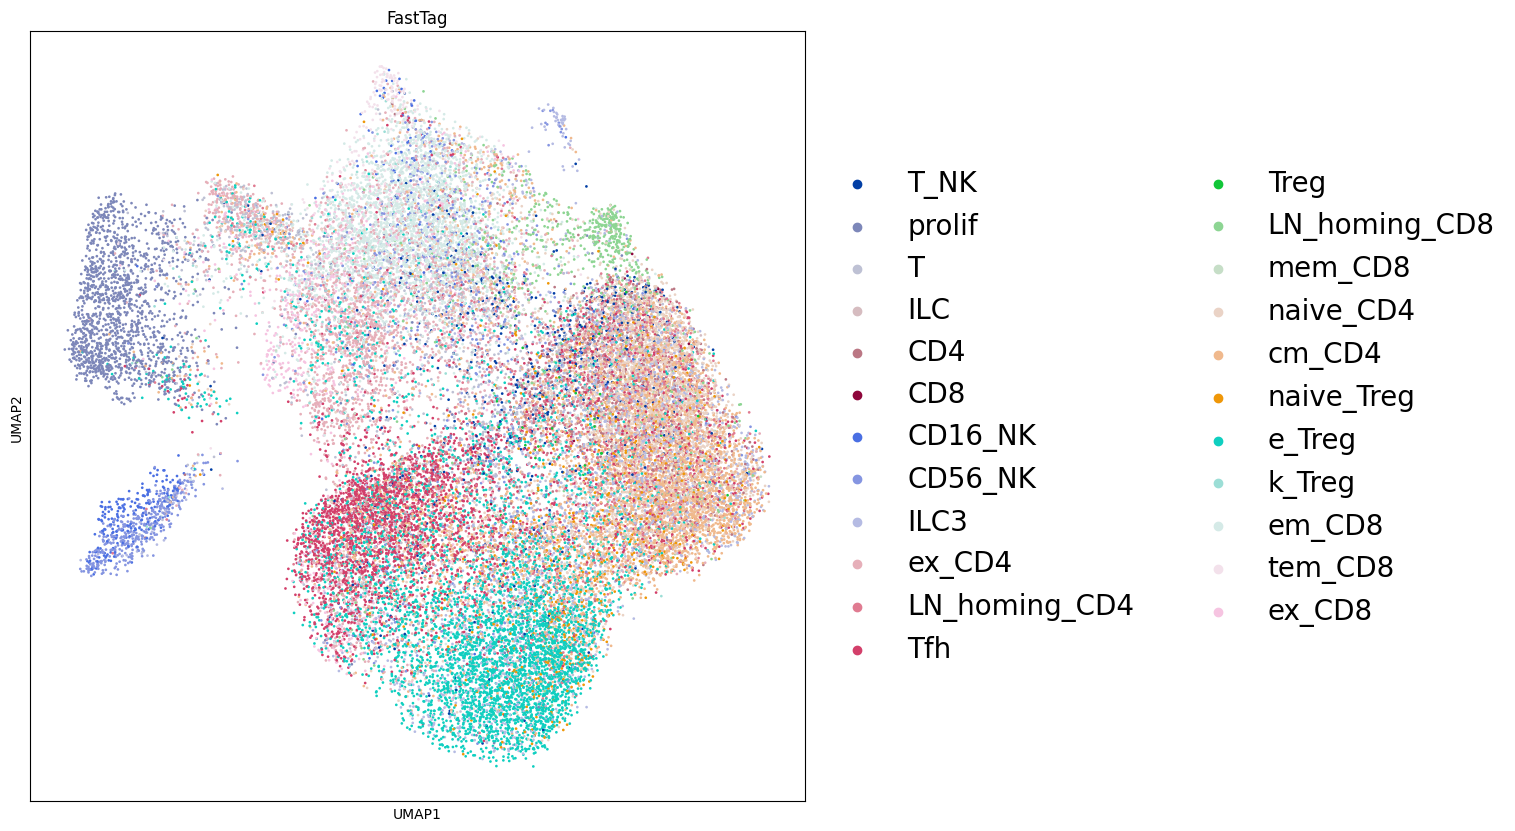

In [138]:
plt.rcParams['figure.figsize'] = (10,10)
# Define a color for missing values that is unlikely to be in the palette
na_color = '#CCCCCC' # Use a light grey color

sc.pl.umap(
  adata=adata,
  # color= ['FastTag'] + subscores ('T_NK',adata,ontology_yaml='ontology_TIL.yaml'),
  color = ['FastTag'],
  # color = markers('ex_CD8',adata=adata, sign = 'pos'),
  # color= subscores ('cell_state',adata),
  # color= ['CD4', 'CD40LG', 'GZMA','GZMK', 'NKG7', 'EOMES'],
  # palette = set4,
  use_raw = True,
  legend_loc='right margin', legend_fontsize=20, legend_fontweight='regular',
  ncols=3, size=15, alpha=1,
  vmax= None,
  na_color=na_color # Explicitly set the missing value color
  )

In [57]:
print(adata.var_names[:50])

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49'],
      dtype='object')


### FastTag+UMAP

In [ ]:
adata = FastTag(adata=adata, ontology_yaml='ontology_TIL.yaml', # 'coarse.yaml','ontology_TIL.yaml'
                markers_yaml='markers.yaml', smoothing_cycles=1,
                majority_vote=True, root = 'T_NK')
sc.pl.umap(
  adata=adata,
  color ='FastTag',
  legend_loc='on data', legend_fontsize=10, legend_fontweight='regular',
  use_raw = True, size = 20, ncols= 3)

### Plot ontology

In [ ]:
G, normalized_markers = init_ontology('ontology.yaml', 'markers.yaml', root='PBMC')
palette = make_palette(lineage_to_cells, lineage_to_color)
plot_ontology(G, root='PBMC', vertex_size=55, vertex_label_size=9, bbox=(1600,1200), palette=palette)


In [ ]:
adata

### Dot Plot

In [ ]:
# Dot Plot
genes = ['CMTM6', 'BCL2', 'S100A4', 'IL2RA', 'IL32',
'NME2', 'MYL12A', 'PIM1', 'CORO1B', 'FLT3LG',
'CISH', 'PDE4B', 'TNFRSF1B', 'ENO1', 'CYLD',
'LGALS1', 'ARL4C', 'ARPC1B', 'UPP1', 'NDUFV2',
'ARL6IP5', 'GNG2', 'G3BP2', 'HIGD2A', 'CLIC1',
'PCED1B', 'PIM2', 'RASSF5', 'COX8A', 'ARPC5L',
'SOCS2', 'PPP1R18', 'PPM1G', 'LGALS3', 'METTL9',
'RAB11FIP1', 'PTGER2', 'PAG1', 'CMTM3', 'PHTF2',
'SGK1', 'UBALD2', 'NPDC1', 'ACTN4', 'DGKE',
'SLC37A3', 'CBFB', 'STIP1', 'TNFRSF18', 'TNFRSF4']

# Convert 'week' to string to avoid potential interval issues in dotplot
# adata.obs['week_str'] = adata.obs['week'].astype(str)

sc.pl.dotplot(adata, vmax= 1.5,
              var_names=genes,
              groupby='treatment', # Use the new string column for grouping
              cmap='Greens',
              standard_scale=None,  dendrogram=False, use_raw=True, figsize=(25, 1))

### Gene heatmap

In [ ]:
#gene heatmap

sc.pl.matrixplot(adata, groupby = 'FastTag', dendrogram = True,
                  var_names = ['TYROBP','XCL2', 'GZMB','CD3D','CD3G','CD8A','CD8B',
                               'CCL5','GZMH','GZMK','NCR3','SLC4A10',
                               'CD40LG', 'CD4','SELL','CCR7','TCF7','GATA3','ANXA1',
                               'CXCR5', 'TOX2', 'CXCL13',
                               'FOXP3', 'IL2RA', 'TIGIT','TYMS','MKI67']
                  ,standard_scale = 'var')

## Stats

In [ ]:
auc_full = volcano_auc_from_raw(df=DGE_genes, fold_change_col='fold_change', pval_col='pval')
print("Full-range volcano AUC:", auc_full)

### T Test

In [ ]:
pb_df = generate_pseudobulk_matrix(adata_dict, cell_type='Treg', groupby_cols=['patient', 'treatment_group'])

# Run the fast paired t-test
res = fast_filtered_paired_ttest(
    pb_df,
    cond1='PBMC',
    cond2='TIL',
    expr_threshold=0.1,       # at least 10% of treated patients must express the gene
    fold_change_threshold=1.5 # fold change must be ≥ 1.5
)

# View the top differentially expressed genes
res.head(20)


In [ ]:
# Purge FastTag categories with 0 cells
print("FastTag categories before purging:", adata.obs['FastTag'].cat.categories.tolist())
initial_cell_count = adata.n_obs

purge(adata, column='FastTag', min_count=1)

print("FastTag categories after purging:", adata.obs['FastTag'].cat.categories.tolist())
print(f"Number of cells before purging: {initial_cell_count}")
print(f"Number of cells after purging: {adata.n_obs}")

In [ ]:
def paired_ttest_pseudobulk(pb_df, gene, group_col='treatment_group', subject_col='patient',
                            cond1='untreated', cond2='treated', min_subjects=3):
    """
    Run one-sided paired t-test (cond2 > cond1) on pseudobulk expression data.
    """
    df = pb_df[[subject_col, group_col, gene]].dropna()

    # Pivot to subject × condition
    df_wide = df.pivot(index=subject_col, columns=group_col, values=gene)

    # Drop patients missing either condition
    df_paired = df_wide.dropna()

    if len(df_paired) < min_subjects:
        print(f"❌ Not enough paired samples (found {len(df_paired)}). Skipping.")
        return None

    # Perform one-sided paired t-test: cond2 > cond1
    t_stat, pval_two_sided = ttest_rel(df_paired[cond2], df_paired[cond1])
    pval_one_sided = pval_two_sided / 2 if t_stat > 0 else 1.0

    # Compute fold change
    fc = (df_paired[cond2].mean() + 1e-6) / (df_paired[cond1].mean() + 1e-6)

    return pd.DataFrame({
        'gene': [gene],
        'fold_change': [fc],
        'pval_one_sided': [pval_one_sided],
        'n_pairs': [len(df_paired)]
    })


In [ ]:
# Run test for one gene
pb_df = generate_pseudobulk_matrix(adata, groupby_cols=['mel_id', 'tissue'])
res = paired_ttest_pseudobulk(pb_df, gene='IL2_score')
print(res)


In [ ]:
pb_df = generate_pseudobulk_matrix(adata_dict, cell_type='Treg', groupby_cols=['patient', 'treatment_group'])
import pandas as pd
from scipy.stats import ttest_rel

def group_ttest(pb_df, cond1='untreated', cond2='treated',
                                    expr_threshold=0.1, fold_change_threshold=1.5,
                                    subject_col='patient', group_col='treatment_group'):
    """
    Run one-sided paired t-test for all genes, filtering by expression in cond2 and fold change.
    Filters are ordered from least to most computationally expensive.
    """
    gene_cols = pb_df.columns.difference([subject_col, group_col])
    results = []

    for gene in gene_cols:
        # Prepare data for current gene
        temp_df = pb_df[[subject_col, group_col, gene]].rename(columns={gene: 'expr'})
        df_wide = temp_df.pivot(index=subject_col, columns=group_col, values='expr')

        # Skip if conditions not both present
        if cond1 not in df_wide.columns or cond2 not in df_wide.columns:
            continue

        # Drop patients missing either condition
        df_wide = df_wide[[cond1, cond2]].dropna()

        # Skip if not enough paired patients
        if df_wide.shape[0] < 3:
            continue

        # Expression threshold in cond2
        expr_pct = (df_wide[cond2] > 0).sum() / df_wide.shape[0]
        if expr_pct < expr_threshold:
            continue

        # Run paired one-sided t-test (cond2 > cond1)
        t_stat, pval = ttest_rel(df_wide[cond2], df_wide[cond1], alternative='greater')

        # Compute fold change
        fc = (df_wide[cond2].mean() + 1e-6) / (df_wide[cond1].mean() + 1e-6)
        if fc < fold_change_threshold:
            continue

        # Store result
        results.append({
            'gene': gene,
            'fold_change': fc,
            'expr_pct_treated': expr_pct,
            'pval': pval,
            'n_pairs': df_wide.shape[0]
        })

    return pd.DataFrame(results).sort_values('pval')



res = group_ttest(pb_df)
res.head(50)



In [ ]:
# prompt: Using dataframe res: volcano plot

import altair as alt

# Create a new column for the negative log10 of the p-value
res['-log10(pval)'] = -1 * res['pval'].apply('log10')

# Create the volcano plot
chart = alt.Chart(res).mark_point().encode(
    # Map fold change to the x-axis
    x='fold_change',
    # Map the negative log10 of the p-value to the y-axis
    y='-log10(pval)',
    tooltip=['gene', 'fold_change', 'pval']
).properties(
    title='Volcano Plot'
).interactive()

# Display the chart
chart

In [ ]:
from matplotlib import pyplot as plt
_df_0['fold_change'].plot(kind='hist', bins=20, title='fold_change')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
_df_0['fold_change'].plot(kind='hist', bins=20, title='fold_change')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
_df_0['fold_change'].plot(kind='hist', bins=20, title='fold_change')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
gc.collect()

In [ ]:
# Load and apply metadata
meta = pd.read_csv('/content/drive/MyDrive/Documents/metadata.csv', index_col='sample_id')
adata.obs = adata.obs.join(meta, on='sample_id')

In [ ]:
# Run your DGE function and get full DataFrame
dge_df = DGE(
    adata=adata,
    groupby='classification',
    target_group='Sarcoidosis',
    reference_group='Control',
    min_pct=0.1,
    min_fold_change=1.1,
    n_genes=None,
    n_sample=10000,
    return_df=True
)

# Adjust p-values and compute –log10
dge_df['pval_adj'] = multipletests(dge_df['pval'], method='fdr_bh')[1]
dge_df['neglog10_padj'] = -np.log10(dge_df['pval_adj'] + 1e-300)  # to avoid log(0)

# Save to Google Drive
output_path = '/content/drive/MyDrive/Documents/Sarcoidosis/dge_results.csv'  # adjust as needed
dge_df.to_csv(output_path, index=False)
print(f"✅ DGE results saved to: {output_path}")


In [ ]:
# prompt: produce a bar plot with average values of "IL2_res_score" by 'Sample type' and  'CoVID-19 severity'

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'adata' AnnData object is loaded and contains the required 'obs' columns
# 'Sample type' and 'CoVID-19 severity' are in adata.obs
# 'IL2_res_score' is also in adata.obs

# Group by 'Sample type' and 'CoVID-19 severity' and calculate the mean of 'IL2_res_score'
df_plot = adata.obs.groupby(['Sample type', 'CoVID-19 severity'])['IL2_res_score'].mean().reset_index()

# Pivot the DataFrame for plotting, with 'Sample type' as index and 'CoVID-19 severity' as columns
pivot_df = df_plot.pivot(index='Sample type', columns='CoVID-19 severity', values='IL2_res_score')

# Plotting the bar plot
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', ax=ax, colormap='viridis') # Using viridis colormap

ax.set_ylabel('Average IL2_res_score')
ax.set_xlabel('Sample Type')
ax.set_title('Average IL2_res_score by Sample Type and CoVID-19 Severity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='CoVID-19 Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
adata=adata_full

### split UMAP

In [ ]:
# Define your treatment conditions (or infer from the data)
conditions = adata_full.obs['treatment'].unique().tolist()

# Count cells per condition and find the minimum
counts = adata_full.obs['treatment'].value_counts()
min_n = counts.min()

# Create subplots
fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 5))
gene = 'FastTag'
rng = np.random.default_rng(seed=0)

for cond, ax in zip(conditions, axes):
    # Get all cell barcodes for this condition
    cells = adata_full.obs_names[adata_full.obs['treatment'] == cond]
    # Downsample if necessary
    if len(cells) > min_n:
        chosen = rng.choice(cells, size=min_n, replace=False)
    else:
        chosen = cells
    # Subset AnnData and plot UMAP
    ad = adata_full[chosen].copy()
    sc.pl.umap(
        ad,
        color=gene,
        ax=ax,
        show=False,
        size=5,
        vmax=7,
        legend_loc=None,
        legend_fontsize=12,
        legend_fontweight= 'regular',
        palette = set4,
        title=None
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('')  # this removes the auto-generated 'FastTag' title

plt.tight_layout()
plt.show()
gc.collect()


In [ ]:
adata


### ANOVA + POST-HOC

In [ ]:
table = analyze_cell_type_distribution(adata, groupby='disease',
    control_group='normal', key_added='FastTag', sample = "donor_id", paired = False)
table


### Volcano AUC

In [ ]:
results = []

for cell_type, ad in adata_dict.items():
    try:
        df = DGE(
            adata=ad,
            groupby='treatment',
            target_group=['treated'],
            reference_group='untreated',
            direction = 'both',
            min_pct=0.25,
            min_log2fc=0.15,
            n_genes=None,
            n_sample=5000,
            return_df=True
        )
        if df.empty:
            print(f"⚠️ {cell_type}: No genes passed filtering.")
            continue

        auc_up, auc_down = volcano_auc_split(df)

        results.append({
            'FastTag': cell_type,
            'AUC_up': auc_up,
            'AUC_down': auc_down,
            'n_genes_tested': df.shape[0]
        })
    except Exception as e:
        print(f"❌ {cell_type}: Error – {e}")



# Assuming 'results' is a list of dicts with keys: FastTag, AUC_up, AUC_down, n_genes_tested
auc_table = pd.DataFrame(results).set_index('FastTag')

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(auc_table.index))

# Bars
bars1 = ax.bar(x - bar_width/2, auc_table['AUC_up'], bar_width, label='Upregulated AUC', color='#1f77b4')
bars2 = ax.bar(x + bar_width/2, auc_table['AUC_down'], bar_width, label='Downregulated AUC', color='#d62728')

# Labels and style
ax.set_xlabel('Cell Type (FastTag)')
ax.set_ylabel('Volcano AUC')
ax.set_title('Volcano AUC by Cell Type (Up vs Down)')
ax.set_xticks(x)
ax.set_xticklabels(auc_table.index, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()





### Timecourse

In [ ]:
sc.tl.score_genes(adata, gene_list=markers ('IL2_res'), score_name='IL2_score')
# adata.obs['IL2_score_minmax'] = minmax_scale(adata.obs['IL2_score'])

In [ ]:
adata.obs['COND_numeric'] = adata.obs['COND'].map({'H': 0, 'T1D': 1}).astype(float)

In [ ]:
genes =['VIM']
for gene in genes:
  plot_timecourse(
  adata = adata,
  relative = False,
  features=[gene], # features should be a list
  patient_key=None,
  time_key='COND_numeric',
  split_by= None,
  color_by = 'sample_id',
  sem= True,
  palette=  plt.cm.winter,
  figsize=(5, 4))

### Cell time course

In [ ]:
# Convert 'timepoint' column to integers before calling the function
# Extract the number part from the string and convert to integer
adata.obs['timepoint_int'] = adata.obs['timepoint'].str.replace('d', '').astype(int)


cell_time_course(
    adata,
    patient_key='patient',
    time_key='week', # Use the new integer timepoint column
    key_added='FastTag',
    cell_label='Treg',
    figsize=(8, 4),
    split_by = "trial",
    palette=  plt.cm.winter
)

### Produce pseudobulk

In [ ]:
pb_Treg = generate_pseudobulk_matrix(adata, groupby_cols=['patient', 'treatment'])


def plot_pseudobulk_timecourse(pb_df, gene: str, time_col='treatment', subject_col='patient'):

    df = pb_df[[subject_col, time_col, gene]].dropna()


    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(data=df, x=time_col, y=gene, hue=subject_col, marker="o")

    # Move legend to the right
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(f"{gene} by patient over time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_pseudobulk_timecourse(pb_Treg, gene='TOMM22')

In [ ]:
ttest_pseudobulk(pb_df=pb_Treg,gene="CISH",alternative='neg')

In [ ]:
def scan_ttest_all_genes(
    pb_df,
    gene_list=None,
    condition_col="treatment",
    subject_col="patient",
    paired=True,
    alternative="neg",
    alpha=0.05,
):
    """
    Run t-test for all genes in pseudobulk matrix and return sorted significant hits.

    Parameters
    ----------
    pb_df : pd.DataFrame
        Pseudobulk matrix.
    gene_list : list of str or None
        List of gene columns to test. If None, infer from pb_df (exclude obs columns).
    condition_col : str
        Column for treatment/condition.
    subject_col : str
        Column for subject ID.
    paired : bool
        Use paired t-test.
    alternative : str
        'both', 'pos', or 'neg' for direction of test.
    alpha : float
        Significance threshold (default = 0.05).

    Returns
    -------
    pd.DataFrame with columns: gene, p_value, t_stat, passed
        Sorted by p-value ascending.
    """
    import pandas as pd

    obs_cols = {condition_col, subject_col}
    if gene_list is None:
        gene_list = [col for col in pb_df.columns if col not in obs_cols]

    results = []

    for gene in gene_list:
        try:
            t_stat, p_val, _ = ttest_pseudobulk(
                pb_df, gene, condition_col, subject_col, paired, alternative
            )
            results.append({
                "gene": gene,
                "p_value": p_val,
                "t_stat": t_stat,
                "passed": p_val < alpha
            })
        except Exception as e:
            # Skip genes that fail (e.g. due to too many NaNs)
            continue

    res_df = pd.DataFrame(results)
    res_df = res_df[res_df["passed"]].sort_values("p_value").reset_index(drop=True)
    return res_df

res_df = scan_ttest_all_genes(
    pb_df=pb_Treg,
    alternative='neg'
)

res_df ['gene'].head(50)



In [ ]:
# Calculate average IL2_res_score for each LIB, COND, and FastTag combination
score_table = adata.obs.groupby(['sample'])['IL2_score'].mean().unstack()

# Skip rows with missing values (samples with more than one COND)
score_table_filtered = score_table.dropna()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(score_table_filtered, cmap='viridis', annot=True, fmt=".2f")
plt.title('Average IL2_res_score by LIB, COND, and FastTag (Filtered)')
plt.xlabel('FastTag')
plt.ylabel('LIB and COND')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
res_df ['gene'].head(50)

In [ ]:

# Create a mapping with "00" prefix and string keys
patient_trial_map = {
    "002003": "TILT", "002004": "TILT", "002005": "TILT", "002008": "T1D", "002009": "TILT",
    "002011": "TILT", "002015": "T1D", "002017": "T1D", "002018": "T1D", "002019": "T1D",
    "002022": "T1D", "007001": "TILT", "007002": "TILT", "007003": "TILT", "007005": "TILT",
    "007101": "T1D", "007102": "T1D", "007103": "T1D"
}

# Convert patient IDs to strings with "00" prefix
adata.obs['patient_str'] = '00' + adata.obs['patient'].astype(str)

# Map to trial column

adata.obs['trial'] = adata.obs['patient'].astype(str).map(patient_trial_map)



In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
pb_Treg['label'] = (pb_Treg['treatment'] == 'treated').astype(int)

# 1. Subset to preselected genes
X = pb_Treg[genes]
y = pb_Treg['label']  # make sure this is 0 (control) / 1 (IL-2 treated)

# 2. Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 3. Standardize gene expression (important for L1 regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Fit L1-penalized logistic regression with cross-validation
clf = LogisticRegressionCV(
    penalty='l1',
    solver='saga',
    cv=5,
    scoring='roc_auc',
    max_iter=10000,
    random_state=42
)
clf.fit(X_train_scaled, y_train)

# 5. Predict on test set and compute AUC
y_probs = clf.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_probs)

# 6. Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('IL-2 Exposure Classifier (Logistic Regression)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 7. Extract selected genes (non-zero coefficients)
coefs = pd.Series(clf.coef_[0], index=genes)
selected_genes = coefs[coefs != 0].sort_values(key=abs, ascending=False)
print("Selected genes and their coefficients:\n")
print(selected_genes)


In [ ]:
adata.obs['week'] = adata.obs['timepoint'].str.lstrip('d').astype(int) // 7

### Scatterplot

In [ ]:
adata.obs['group'].unique()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define order and colors
treatment_order = ['H_untreated', 'T1D_untreated', 'T1D_treated']
custom_palette = {'H_untreated': 'blue', 'T1D_untreated': 'darkcyan', 'T1D_treated': 'green'}

# Compute per-sample average IL2 score
avg_df = (
    adata.obs.groupby(['group', 'sample'])['IL2_score']
    .mean()
    .reset_index()
)
avg_df['group'] = pd.Categorical(avg_df['group'], categories=treatment_order, ordered=True)

# Compute mean per group (for horizontal bars)
mean_scores = avg_df.groupby('group', sort=False)['IL2_score'].mean()

# Plot
plt.figure(figsize=(4, 6))
ax = plt.gca()

# Swarmplot (goes behind)
sns.swarmplot(
    data=avg_df,
    x='group', y='IL2_score',
    hue='group', palette=custom_palette,
    order=treatment_order, hue_order=treatment_order,
    size=5, ax=ax, zorder=1
)

# CI-only pointplot (on top)
sns.pointplot(
    data=avg_df,
    x='group', y='IL2_score',
    estimator='mean', errorbar='ci',
    capsize=0.05, color='black',
    errwidth=1, linewidth=0,
    order=treatment_order, ax=ax, zorder=10
)

# Horizontal mean bars
for i, group in enumerate(treatment_order):
    ax.hlines(mean_scores[group], i - 0.2, i + 0.2, color='black', linewidth=1.5, zorder=11)

from scipy.stats import f_oneway

# Extract groups
groups = [avg_df.loc[avg_df['group'] == g, 'IL2_score'] for g in treatment_order]

# Run one-way ANOVA
groups = [
    avg_df.loc[avg_df['group'] == g, 'IL2_score'].dropna()
    for g in treatment_order
]
f_stat, p_val = f_oneway(*groups)

# Annotate p-value on plot
ax.text(
    0.5,                        # x-position (centered)
    ax.get_ylim()[1] * 0.95,    # y-position (top 5%)
    f"ANOVA p = {p_val:.4e}",   # formatted p-value
    ha='center', fontsize=10
)

# Styling
ax.set_title('Average IL2_score per Sample ID by group with Mean and 95% CI')
ax.set_xlabel('group')
ax.set_ylabel('Average IL2_score per Sample')
ax.set_xticks(range(len(treatment_order)))
ax.set_xticklabels(treatment_order)
ax.legend([], [], frameon=False)  # Remove redundant hue legend

# Overlay: different markers for dataset_origin
avg_df['x_numeric'] = avg_df['group'].cat.codes  # get numeric x positions
sns.scatterplot(
    data=avg_df,
    x='x_numeric', y='IL2_score',
    style=adata.obs.loc[avg_df['sample'], 'dataset_origin'].values,
    markers={'A': 'o', 'H': 's'}, s=50,
    hue='group', palette=custom_palette,
    ax=ax, legend=False, zorder=2
)

plt.tight_layout()
plt.show()





In [ ]:
# Group display order and colors
group_order = ['H_untreated', 'T1D_untreated', 'T1D_treated']
color_map = {'H_untreated': 'blue', 'T1D_untreated': 'darkcyan', 'T1D_treated': 'green'}
marker_map = {'H': 's', 'A': 'o'}  # H = Healthy, A = Autoimmune

# Compute per-sample averages
avg_df = (
    adata.obs.groupby(['group', 'sample', 'dataset_origin'])['IL2_score']
    .mean()
    .reset_index()
)
avg_df['group'] = pd.Categorical(avg_df['group'], categories=group_order, ordered=True)

# Compute group means and 95% CIs
summary_stats = avg_df.groupby('group')['IL2_score'].agg(['mean', 'count', 'std'])
summary_stats['ci95'] = 1.96 * summary_stats['std'] / np.sqrt(summary_stats['count'])

# Plot setup
fig, ax = plt.subplots(figsize=(4, 6))
rng = np.random.default_rng(seed=42)

# Scatter each point with color + marker by group and origin
for i, group in enumerate(group_order):
    sub = avg_df[avg_df['group'] == group]
    jittered_x = rng.normal(loc=i, scale=0.08, size=len(sub))
    for x, y, origin in zip(jittered_x, sub['IL2_score'], sub['dataset_origin']):
        ax.scatter(
            x, y,
            color=color_map[group],
            marker=marker_map.get(origin, 'o'),
            edgecolor='black',
            linewidth=0.4,
            s=40,
            alpha=0.85
        )

# Add CI bars and mean lines
for i, group in enumerate(group_order):
    mean = summary_stats.loc[group, 'mean']
    ci = summary_stats.loc[group, 'ci95']
    ax.errorbar(
        i, mean, yerr=ci,
        fmt='none', ecolor='black', elinewidth=1.2, capsize=4, zorder=10
    )
    ax.hlines(mean, i - 0.2, i + 0.2, color='black', linewidth=1.5, zorder=11)

# Optional legend for marker shape
import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='black', marker='s', linestyle='None', label='Healthy dataset', markersize=6),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Autoimmune dataset', markersize=6),
]
ax.legend(handles=legend_elements, title='Origin', loc='upper left')

# Styling
ax.set_title('Average IL2_score per Sample by Group and Origin')
ax.set_xticks(range(len(group_order)))
ax.set_xticklabels(group_order)
ax.set_ylabel('IL2_score')
plt.tight_layout()
plt.show()


In [ ]:
# === Step 1: Score genes and split ===

if True:
    gene_set_names = [
        'e_Treg',
        'IL2_res'
    ]
    score_names = [name + "_score" for name in gene_set_names]

    for gene_set in gene_set_names:
        sc.tl.score_genes(adata, markers(gene_set), score_name=gene_set + "_score")

    adata_dict = split(adata, category='FastTag', min_cells=30)

# === Step 2: Aggregate per-donor scores for each cell type ===

cell_type_1 = "Treg"
cell_type_2 = "Treg"

donor_scores = {}

for cell_type in [cell_type_1, cell_type_2]:
    ad = adata_dict.get(cell_type)
    if ad is None:
        raise ValueError(f"No data found for cell type {cell_type}")

    df = (
        ad.obs
        .groupby("donor_id", observed=True)[score_names]
        .mean()
        .add_prefix(f"{cell_type}_")
    )
    donor_scores[cell_type] = df

# Merge dataframes on donor_id
df_scores = pd.concat(donor_scores.values(), axis=1, join="inner").reset_index()

# === Step 3: Correlation analysis ===

score_1 = f"{cell_type_1}_IL2_res_score"
score_2 = f"{cell_type_2}_e_Treg_score"

# Ensure both columns exist
for col in [score_1, score_2]:
    if col not in df_scores.columns:
        raise KeyError(f"Missing column: {col}")

# Pearson correlation
r, p = pearsonr(df_scores[score_1], df_scores[score_2])
print(f"Pearson r = {r:.2f}, p = {p:.3g}")

# === Step 4: Plot ===

plt.figure(figsize=(6, 5))
sns.regplot(
    data=df_scores,
    x=score_1,
    y=score_2,
    scatter_kws={'s': 60},
    line_kws={'color': 'gray'}
)
plt.xlabel(score_1)
plt.ylabel(score_2)
plt.title(f"Per-donor correlation\nr = {r:.2f}, p = {p:.3g}")
plt.grid(True)
plt.tight_layout()
plt.show()


## Save files

In [ ]:
# to Drive
adata.write ('Dong/Dong_T.h5ad') # save file

In [ ]:
# to google cloud

adata.write ("/content/FL_T.h5ad")
blob = bucket.blob("FL/FL_T.h5ad")
blob.upload_from_filename("/content/FL_T.h5ad")
blob = bucket.blob("markers.yaml"); blob.upload_from_filename("markers.yaml")
blob = bucket.blob("ontology.yaml"); blob.upload_from_filename("ontology.yaml")
blob = bucket.blob("ontology_TIL.yaml"); blob.upload_from_filename("ontology_TIL.yaml")
blob = bucket.blob("coarse.yaml"); blob.upload_from_filename("coarse.yaml")
blob = bucket.blob("notes.txt"); blob.upload_from_filename("notes.txt")